# **Detecting and Defending against AdversarialExamples in Deep Neural Networks** #
##by *Anna Kerebel*, *Florian Jacta*, *Rose Guionnet*, *Swen Laurent*, *Théo Di Piazza* and *Victor Klötzer*

### Referents: *Ayse Nur Arlsan* and *Wassim Hamidouche* 

December 2020

# **Class `Image`**

Creation of the Python class : `Image`. It will collect a lot of useful information on the attacks of an image. It is created from an image (type np.array or torch.tensor) and the label associated (here from 0 to 9 representing the different "objects").   
These are the attributs of each `Image` object:
- `.original` : original image
- `.label` : original label
- `.attack_[nom de l'attaque]` : image attacked by [name of the attack used]
- `.label_[nom de l'attaque]` : associated label of the attacked image [name of the attack used]
- `.coefs_original` : MSCN coefficients of original image
- `.coefs_[nom de l'attaque]` : MSCN coefficients of the attacked image [name of the attack used]

In [131]:
class Image:
  """ Class collecting the attacked image and their labels but also the corresponding MSCN coefficients """
  def __init__(self):
    self.original = None # originale image  (not-attacked)
    self.label = None # originale label  (not-attacked)

    self.attack_FGSM = None # Image attacked by FGSM
    self.label_FGSM = None # label given by the NN
    self.attack_PGD = None
    self.label_PGD = None
    self.attack_DF = None
    self.label_DF = None
    self.attack_CW = None
    self.label_CW = None
    
    self.coefs_original = None
    self.coefs_FGSM = None
    self.coefs_PGD = None
    self.coefs_DF = None
    self.coefs_CW = None

    self.features_original = None # Parameters to estimate the law of the orginal image
    

# **1. Deep Neural Networks creation and generation of adersarial attacks**

## Importation of Python modules

In [132]:
# RESSOURCE : https://pytorch.org/docs/stable/index.html

# importation des differents packages
# Reseaux neuronaux
import torch                  # package de structures de donnees pour tenseurs multi-d et applications mathematiques
import torch.nn as nn         # module pour construction de graphes
import torch.optim as optim   # module d'algorithmes d'optimisation 
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import math
import copy
import os

#from PIL import Image


import matplotlib.pyplot as plt # module graphique 
import numpy as np

In [133]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #consideration d'allocation memoire, technique, pas grave si pas compris

In [134]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Importation des donnees

# datasets.MNIST correspond a la banque d'images de chiffres ecrits a la main 
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True) #shuffle=melanger // batch=groupe-lot
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

## Creation of NN and training #

## MNIST

In [135]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1) # x.view(a,b) is like reshape x, x.view(c,-1) lets you have a matrix with c lines

# we will consider 3 NN

# NN with 2 layers
model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)# 784 is the number of pixels and 10 is the number of probabilities to be estimated for the 10 labels

# 4 layers NN
model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

# 4 layers CNN + 1 layer : if we want to test the model with a single image. We have to have as an input a tensor of size (1,1,28,28)
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)


Training function and test function

In [136]:
def epoch(loader, model, opt=None):

  # initialiation
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device) # X sont les donnees d'entrees (les pixels d'une image) et y sont les donnees de sorties (bonne classe)
        yp = model(X) # on applique notre modele a X
        loss = nn.CrossEntropyLoss()(yp,y) # on calcule la fonction de perte
        if opt: # optimisation si opt present
            opt.zero_grad() # ini du gradient
            loss.backward() # calcul du gradient
            opt.step() # etape d'optimisation
        
        #yp.max(1) donne les valeurs max selon les lignes de yp ([1] c'est pour ne retenir que ces valeurs, puisqu'y.max(1) rend aussi les indices associes)
        total_err += (yp.max(dim=1)[1] != y).sum().item() # si on  pas pris la bonne classe alors on somme les erreurs ?
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset) # pourcentage d'erreur et pourcentage de loss

Training of the 2 layers NN

In [137]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt) # training, output erros and loss
    test_err, test_loss = epoch(test_loader, model_dnn_2) # testing with the test dataloader, output error and loss
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t") # display

accurDNN2 = 1 - test_err

0.131933	0.513729	0.080500	0.290835
0.075683	0.267245	0.066900	0.226556
0.060433	0.210533	0.054000	0.188360
0.049717	0.173203	0.047600	0.163661
0.041967	0.147774	0.041800	0.141267
0.036533	0.128560	0.035200	0.122545
0.031850	0.113379	0.034800	0.115146
0.028733	0.101611	0.030800	0.104446
0.025450	0.091801	0.029500	0.098052
0.022800	0.083412	0.027400	0.093258


Training of the 4 layers NN

In [138]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1) 
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

accurDNN4 = 1 - test_err

0.252967	0.808143	0.081900	0.274981
0.065600	0.223643	0.051000	0.166713
0.044017	0.148304	0.041200	0.132125
0.032517	0.110316	0.036700	0.112632
0.026017	0.086032	0.031200	0.101664
0.021600	0.070168	0.031400	0.098319
0.017817	0.058239	0.024500	0.082372
0.014933	0.048881	0.023900	0.075791
0.011750	0.040671	0.023200	0.074491
0.010233	0.034211	0.024000	0.074240


Training of the CNN

In [139]:
# long to run
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(5):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

accurCNN = 1 - test_err

0.200267	0.597363	0.026600	0.089581
0.026050	0.084348	0.026100	0.081501
0.017517	0.056604	0.013800	0.047190
0.012833	0.040741	0.013300	0.043993
0.009917	0.030937	0.013900	0.038782


Compare the models

Text(0.5, 1.0, 'Error of the models')

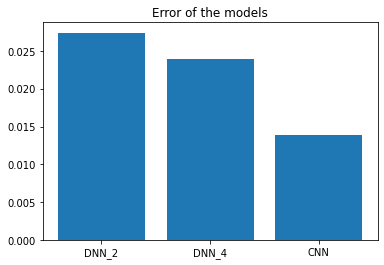

In [140]:
names = ['DNN_2', 'DNN_4', 'CNN']
values = [1 - accurDNN2, 1 - accurDNN4, 1 - accurCNN]

plt.bar(names, values)
plt.title("Error of the models")

Saving and loading

In [141]:
from google.colab import files

torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt") # save the NN 
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

# To download the files
#files.download('model_dnn_2.pt')
#files.download('model_dnn_4.pt')
#files.download('model_cnn.pt')

In [142]:
# Load the NN
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

Attribution de X et y et displaying function

In [143]:
# initialise X comme les entrees et y comme les sortie
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
# affichage des images
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

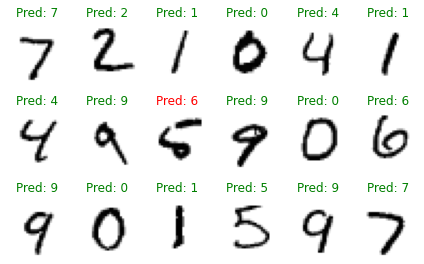

In [144]:
### Illustrate original predictions
yp = model_dnn_2(X) # le modele a deja ete entraine
plot_images(X, y, yp, 3, 6)

## FGSM attack

In [145]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

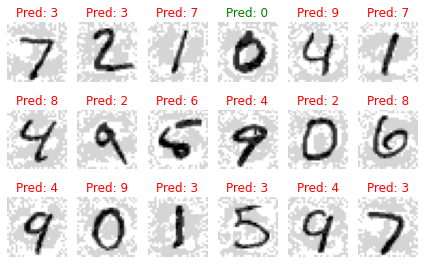

In [146]:
### Images attaquées : 2 couches
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

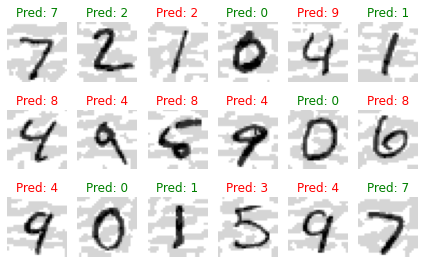

In [147]:
### Images attaquées CNN
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [148]:
def epoch_adversarial(model, loader, attack, *args): # on utilise l'attaque (ici FGSM) pour trouver un yp qu'on va comparer au vrai y, nsuite on regarde l'erreur et la loss associé
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

Error

In [19]:
errDNN2 = epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0]
print("2-layer DNN:", errDNN2)
errDNN4 = epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0]
print("4-layer DNN:", errDNN4)
errCNN = epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0]
print("        CNN:", errCNN)

2-layer DNN: 0.9245
4-layer DNN: 0.939
        CNN: 0.5002


Text(0.5, 1.0, 'Accuracy of FGSM on the models')

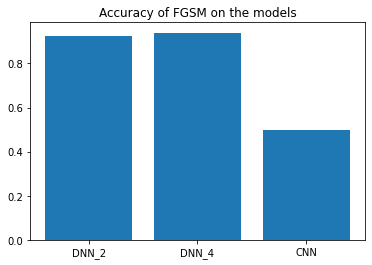

In [20]:
names = ['DNN_2', 'DNN_4', 'CNN']
values = [errDNN2, errDNN4, errCNN]

plt.bar(names, values)
plt.title("Accuracy of FGSM on the models")

Evaluating FGSM's accuracy for several $\epsilon$

In [21]:
#long to run
vec_errDNN2=[]
vec_errDNN4=[]
vec_errCNN=[]
Eps=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.09,0.08,0.1,0.12,0.14,0.17,0.2,0.3,0.5,0.8]
for eps in Eps:
  vec_errDNN2.append(epoch_adversarial(model_dnn_2, test_loader, fgsm, eps)[0])
  vec_errDNN4.append(epoch_adversarial(model_dnn_4, test_loader, fgsm, eps)[0])
  vec_errCNN.append(epoch_adversarial(model_cnn, test_loader, fgsm, eps)[0])


Text(0.5, 1.0, 'Error rate of FGSM attack for several epsilon')

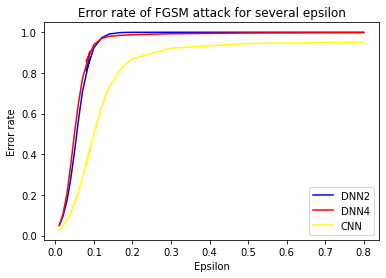

In [22]:
plt.plot(Eps,vec_errDNN2,label='DNN2',color='blue')
plt.plot(Eps,vec_errDNN4,label='DNN4',color='red')
plt.plot(Eps,vec_errCNN,label='CNN',color='yellow')
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title("Error rate of FGSM attack for several epsilon")

## PGD attack #

In [149]:
def pgd(model, X, y, epsilon, alpha, num_iter): # the same as FGSM but multiple times
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

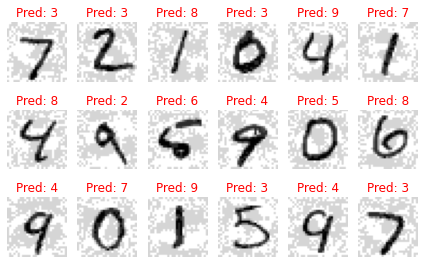

In [150]:
### Illustrate attacked images
delta = pgd(model_dnn_4, X, y, 0.1, 1e4, 500)
yp = model_dnn_4(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [151]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

7.539301805081777e-06


In [152]:
nbIttDNN = 50
nbIttCNN = 5
errDNN2 = epoch_adversarial(model_dnn_2, test_loader, pgd, 0.1, 1e4, nbIttDNN)[0]
print("2-layer DNN:", errDNN2)
errDNN4 = epoch_adversarial(model_dnn_4, test_loader, pgd, 0.1, 1e4, nbIttDNN)[0]
print("4-layer DNN:", errDNN4)
errCNN = epoch_adversarial(model_cnn, test_loader, pgd, 0.1, 1e4, nbIttCNN)[0] # long to run
print("CNN:", errCNN) 

2-layer DNN: 0.9624
4-layer DNN: 0.9752
CNN: 0.6099


Text(0.5, 1.0, 'Accuracy of PGD on the models')

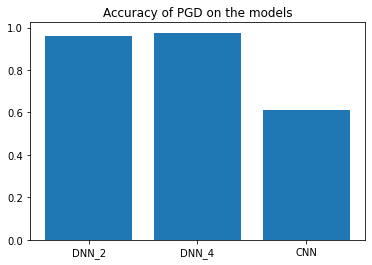

In [153]:
names = ['DNN_2', 'DNN_4', 'CNN']
values = [errDNN2, errDNN4, errCNN]

plt.bar(names, values)
plt.title("Accuracy of PGD on the models")

In [154]:
#very long to run
vec_errDNN2=[]
vec_errDNN4=[]
vec_errCNN=[]

nbIttDNN = 40
nbIttCNN = 10

Eps=[0.01,0.03,0.05,0.07,0.1,0.14,0.2,0.3]
for eps in Eps:
  vec_errDNN2.append(epoch_adversarial(model_dnn_2, test_loader, pgd, eps, 1e4, nbIttDNN)[0])
  vec_errDNN4.append(epoch_adversarial(model_dnn_4, test_loader, pgd, eps, 1e4, nbIttDNN)[0])
  vec_errCNN.append(epoch_adversarial(model_cnn, test_loader, pgd, eps, 1e4, nbIttCNN)[0])
  print(eps)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(Eps,vec_errDNN2,label='DNN2 40 iterations',color='blue')
plt.plot(Eps,vec_errDNN4,label='DNN4 40 iterations',color='red')
plt.plot(Eps,vec_errCNN,label='CNN 10 iterations',color='yellow')
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title("Error rate of PGD attack for several epsilon")

Pour l'attaque PGD Linf, voir notebook 1

Comparaison PGD et FGSM 

In [ ]:
#long to run
vec_errDNN2_fgsm=[]
vec_errDNN4_fgsm=[]
vec_errCNN_fgsm=[]
Eps=[0.01,0.03,0.05,0.07,0.1,0.14,0.2,0.3]
for eps in Eps:
  vec_errDNN2_fgsm.append(epoch_adversarial(model_dnn_2, test_loader, fgsm, eps)[0])
  vec_errDNN4_fgsm.append(epoch_adversarial(model_dnn_4, test_loader, fgsm, eps)[0])
  vec_errCNN_fgsm.append(epoch_adversarial(model_cnn, test_loader, fgsm, eps)[0])

In [ ]:
plt.plot(Eps,vec_errDNN2,label='PGD DNN2 40 it',color='blue')
plt.plot(Eps,vec_errDNN2_fgsm,'--',label='FGSM DNN2',color='blue')
plt.plot(Eps,vec_errDNN4,label='PGD DNN4 40 it',color='red')
plt.plot(Eps,vec_errDNN4_fgsm,'--',label='FGSM DNN4',color='red')
plt.plot(Eps,vec_errCNN,label='PGD CNN 10 it',color='yellow')
plt.plot(Eps,vec_errCNN_fgsm,'--',label='FGSM CNN',color='yellow')
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title("Error rate of PGD attack against FGSM attack for several epsilons")

## DeepFool attack #

In [155]:
# reference : https://medium.com/@aminul.huq11/pytorch-implementation-of-deepfool-53e889486ed4

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):

    f_image = net.forward(image).cpu().data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            
            #x.zero_grad()
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)
        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).to(device)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [156]:
i=22
r_tot, loop_i, label, k_i, pert_image = deepfool(X[i],model_dnn_2,10, 0.02, 50)

# loop_i  number of iteration
# label : original label
# k_i : label after attack
# pert_image : attaced image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


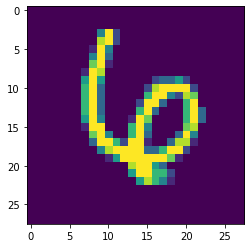

In [157]:
# image before deformation
plt.imshow(X[i].cpu().view(28,28)) 
plt.show() 

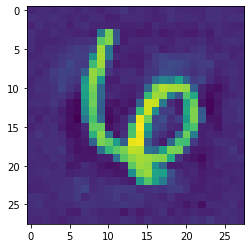

7


In [158]:
# attacked image
plt.imshow(pert_image.cpu().view(28,28)) 
plt.show() 
# label
print(k_i)

Accuracy of DeepFool

In [159]:
total_errDNN2 = 0
total_errDNN4 = 0
total_errCNN = 0

for i in range(1,100):
  r_totDDN2, loop_iDDN2, labelDDN2, k_iDDN2, pert_imageDDN2 = deepfool(X[i],model_dnn_2,10, 0.02, 50)
  r_totDDN4, loop_iDDN4, labelDDN4, k_iDDN4, pert_imageDDN4 = deepfool(X[i],model_dnn_4,10, 0.02, 50)
  r_totCNN, loop_iCNN, labelCNN, k_iCNN, pert_imageCNN = deepfool(X[i].view(1,1,28,28),model_cnn,10, 0.02, 50)

  total_errDNN2 += (labelDDN2 != k_iDDN2)
  total_errDNN4 += (labelDDN2 != k_iDDN2)
  total_errCNN += (labelCNN != k_iCNN)

total_errDNN2/=100
total_errDNN4 /= 100
total_errCNN /= 100

print(total_errDNN2)
print(total_errDNN4)
print(total_errCNN)

names = ['DNN_2', 'DNN_4', 'CNN']
values = [total_errDNN2, total_errDNN4, total_errCNN]

plt.bar(names, values)
plt.title("Accuracy of DeepFool on the models")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

##Comparison of the different attacks in terms of time

Time estimation of DeepFool

In [ ]:
import time


tps1 = time.clock()
for i in range(100):
  r_tot, loop_i, label, k_i, pert_image = deepfool(X[i],model_dnn_2,10, 0.02, 50)
tps2 = time.clock()
tps_DF_DNN2_100=tps2 - tps1

tps1 = time.clock()
for i in range(100):
  r_tot, loop_i, label, k_i, pert_image = deepfool(X[i],model_dnn_4,10, 0.02, 50)
tps2 = time.clock()

tps_DF_DNN4_100=tps2 - tps1

tps1 = time.clock()
for i in range(100):
  r_tot, loop_i, label, k_i, pert_image = deepfool(X[i].view(1,1,28,28),model_cnn,10, 0.02, 50)
tps2 = time.clock()

tps_DF_CNN_100=tps2 - tps1


print(tps_DF_DNN2_100,tps_DF_DNN4_100,tps_DF_CNN_100)


Time estimation of FGSM

In [ ]:
tps1 = time.clock()
epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.13)[0]
tps2 = time.clock()
tps_FGSM_DNN2_100=tps2 - tps1

tps1 = time.clock()
epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.13)[0]
tps2 = time.clock()

tps_FGSM_DNN4_100=tps2 - tps1

tps1 = time.clock()
epoch_adversarial(model_cnn, test_loader, fgsm, 0.13)[0]
tps2 = time.clock()

tps_FGSM_CNN_100=tps2 - tps1


print(tps_FGSM_DNN2_100,tps_FGSM_DNN4_100,tps_FGSM_CNN_100)

Time estimation of PGD

In [ ]:
tps1 = time.clock()
epoch_adversarial(model_dnn_2, test_loader, pgd, 0.13, 1e4, 50)[0]
tps2 = time.clock()
tps_PGD_DNN2_100=tps2 - tps1

tps1 = time.clock()
epoch_adversarial(model_dnn_4, test_loader, pgd, 0.13, 1e4, 50)[0]
tps2 = time.clock()

tps_PGD_DNN4_100=tps2 - tps1


tps1 = time.clock()
epoch_adversarial(model_cnn, test_loader, pgd, 0.13, 1e4, 10)[0]
tps2 = time.clock()

tps_PGD_CNN_100=tps2 - tps1


print(tps_PGD_DNN2_100,tps_PGD_DNN4_100,tps_PGD_CNN_100)

In [ ]:
temps_DNN2=[tps_PGD_DNN2_100,tps_FGSM_DNN2_100,tps_DF_DNN2_100]
temps_DNN4=[tps_PGD_DNN4_100,tps_FGSM_DNN4_100,tps_DF_DNN4_100]
temps_CNN=[tps_PGD_CNN_100,tps_FGSM_CNN_100,tps_DF_CNN_100]

In [ ]:
axes=plt.gca()
plt.bar(["PGD 50 it","FGSM","DF"],temps_DNN2)
axes.set_ylabel("Time in sec")
plt.title("Execution time to attack 100 pictures with a DNN_2")


In [ ]:
axes=plt.gca()
plt.bar(["PGD 50 it","FGSM","DF"],temps_DNN4)
axes.set_ylabel("Time in sec")
plt.title("Execution time to attack 100 pictures with a DNN_4")

In [ ]:
axes=plt.gca()
plt.bar(["PGD 10 it","FGSM","DF"],temps_CNN)
axes.set_ylabel("Time in sec")
plt.title("Execution time to attack 100 pictures with a CNN ")

## Carlini & Wagner attack #

Ne fonctionne pas encore

In [160]:
# reference : https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
from __future__ import print_function

import sys
import tensorflow as tf

In [161]:
MAX_ITERATIONS = 1000   # nombre max d'iteration pour la descente de gradient
ABORT_EARLY = True      # arret de la descente de gradient lorsque l'on toruve une premier solution valide
LEARNING_RATE = 1e-2    # les valeurs plus elevees convergent plus rapidement vers des resultats moins precis
INITIAL_CONST = 1e-3    # la premiere valeur que prendra c
LARGEST_CONST = 2e6     # plus grande valeur que peut prendre c avant d'abandonner
REDUCE_CONST = False    # essayer d'abaisser c a chaque iteration; plus rapide a definir sur false
TARGETED = True         # Doit-on viser une classe specifique? Ou juste induire le systeme en erreur?
CONST_FACTOR = 2.0      # f>1, taux avec lequel on augmente la constant, plus c'est petit mieux c'est

In [162]:
class CarliniL0:

  def __init__(self, sess, model,targeted = TARGETED, learning_rate = LEARNING_RATE, max_iterations = MAX_ITERATIONS, abort_early = ABORT_EARLY, initial_const = INITIAL_CONST, largest_const = LARGEST_CONST,reduce_const = REDUCE_CONST, const_factor = CONST_FACTOR,independent_channels = False):
    """
    Il s'agit ici de l'attaque optimisee C&W pour la distance L_0
    Elle retourne des exemples d'attaques CW pour le modele fourni
    
    Parametres:

    targeted: Vrai si l'attaque est ciblee, faux sinon

    learning_rate: taux d'apprentissage pour l'algorithme d'attaque. De petites valeurs
    fournissent de meilleurs resultats mais sont plus longues a converger.

    max_iterations: nombre maximum d'iteration. De grandes valeurs sont plus precises,
    en definir de trop petites  necessite un taux d'apprentissage important et fournira
    des resultats peu satisfaisants.

    abort_early: Si vrai, permet d'interrompre l'algorithme rapidement si la descente de gradient
    reste "coincee"

    initial_const: La constante de compromis initiale a utiliser pour regler la valeur relative
    importance a donner a la distance et a la confiance. Doit etre une faible valeur, mais positive .
    
    largest_const: La plus grande constante a utiliser jusqu'au signalement d'un echec. Doit etre grande.
    
    const_factor: Le taux avec lequel il faut augmenter la constante, quand la precedente constante ne marche plus.
    Doit etre plus grand que 1, mais plus il est petit mieux c'est.
    
    independent_channels: Si defini sur faux, optimise le nombre de pixels changes. 
    Si defini sur vrai (pas recommande), retourne le nombre de canaux modifies.
  
    """
    self.model = model
    self.sess = sess

    self.TARGETED = targeted
    self.LEARNING_RATE = learning_rate
    self.MAX_ITERATIONS = max_iterations
    self.ABORT_EARLY = abort_early
    self.INITIAL_CONST = initial_const
    self.LARGEST_CONST = largest_const
    self.REDUCE_CONST = reduce_const
    self.const_factor = const_factor
    self.independent_channels = independent_channels

    self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

    self.grad = self.gradient_descent(sess, model)



# METHODE  DE DESCENTE DE GRADIENT

  def gradient_descent(self, sess, model):
    def compare(x,y):
      if self.TARGETED:  # si on est dans le cas d'une attaque ciblee
        return x == y    # retourner le boolean lie a l'egalite des deux instances
      else:              # sinon, si on cherche juste a induire le systeme en erreur
        return x != y    # retourner le boolean confirmant ou non la difference entre les deux instances
        
    shape = (1,model.image_size,model.image_size,model.num_channels) # format souhaite
    # si on utilise shape pour un tenseur:
    # on obtiendra model.image_size fois des matrices de dim model.image_size * model.num_channels


    # Variable a optimiser
    modifier = tf.Variable(np.zeros(shape,dtype=np.float32)) # correspond a wi dans la doc https://fairyonice.github.io/Learn-the-Carlini-and-Wagners-adversarial-attack-MNIST.html

    # les variables que nous allons retenir, a utiliser pour plus d'efficacite
    canchange = tf.Variable(np.zeros(shape),dtype=np.float32) # tenseur qui determinera la possibilite de changement pixel par pixel
    simg = tf.Variable(np.zeros(shape,dtype=np.float32)) # ?
    original = tf.Variable(np.zeros(shape,dtype=np.float32)) # tenseur de l'image originale 
    timg = tf.Variable(np.zeros(shape,dtype=np.float32)) # ?
    tlab = tf.Variable(np.zeros((1,model.num_labels),dtype=np.float32))  # tenseur des labels, pour la sortie (les categories)
    const = tf.placeholder(tf.float32, [])  # la constante c 

    """ explications sur un tf placeholder:
    Un placeholder, espace reserve en fr, est simplement une variable a laquelle nous attribuerons des donnees a une date ulterieure. Cela nous permet de creer nos
    operations et de construire notre graphe de calcul, sans avoir besoin des donnees. Dans la terminologie TensorFlow, nous introduisons ensuite des donnees
    dans le graphique via ces espaces reserves.
    """

    # et l'affectation pour definir les variables
    assign_modifier = tf.placeholder(np.float32,shape)
    assign_canchange = tf.placeholder(np.float32,shape)
    assign_simg = tf.placeholder(np.float32,shape)
    assign_original = tf.placeholder(np.float32,shape)
    assign_timg = tf.placeholder(np.float32,shape) 
    assign_tlab = tf.placeholder(np.float32,(1,self.model.num_labels)) 

    # Variables a initialiser lorsque l'on fait tourner le programme
    set_modifier = tf.assign(modifier, assign_modifier)
    setup = []  
    # installation/ initialisation
    setup.append(tf.assign(canchange, assign_canchange))
    setup.append(tf.assign(timg, assign_timg))
    setup.append(tf.assign(original, assign_original))
    setup.append(tf.assign(simg, assign_simg))
    setup.append(tf.assign(tlab, assign_tlab))
        
    #nouvelle image:
    newimg = (tf.tanh(modifier + simg)/2)*canchange+(1-canchange)*original  # canchange est un tenseur de 0 ou 1
    # pixel par pixel on a:
    # si =0, le pixel n'est pas modifie
    # si =1, le pixel est modifie et vaut (tf.tanh(modifier + simg)/2) 
    # voir https://fairyonice.github.io/Learn-the-Carlini-and-Wagners-adversarial-attack-MNIST.html
    # au niveau de "box constraints"
    # ici wi=modifier, xi=original

    output = model.predict(newimg) # calcul de la sortie avec cette nouvelle image
        
    real = tf.reduce_sum((tlab)*output,1) # somme du tenseur tlab*output sur les colonnes
    # on regarde la valeur donnee a la bonne categorie

    other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)  # restriction sur les colonnes -> maximum sur les lignes
    # 1-tab permet d'obtenir toutes les mauvaises categories, je comprendre pas la partie - (tlab*10000), a quoi ca sert? 
    # on regarde donc ici 

    if self.TARGETED:
    # if targetted, optimize for making the other class most likely
      loss1 = tf.maximum(0.0, other-real+.01)
    else:
    # if untargeted, optimize for making this class least likely.
      loss1 = tf.maximum(0.0, real-other+.01)

    # sum up the losses
    loss2 = tf.reduce_sum(tf.square(newimg-tf.tanh(timg)/2))
    loss = const*loss1+loss2
            
    outgrad = tf.gradients(loss, [modifier])[0]
        
    # setup the adam optimizer and keep track of variables we're creating
    start_vars = set(x.name for x in tf.global_variables())
    optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
    train = optimizer.minimize(loss, var_list=[modifier])

    end_vars = tf.global_variables()
    new_vars = [x for x in end_vars if x.name not in start_vars]
    init = tf.variables_initializer(var_list=[modifier,canchange,simg,
                                                  original,timg,tlab]+new_vars)

        
    def doit(oimgs, labs, starts, valid, CONST):
      # convert to tanh-space
      imgs = np.arctanh(np.array(oimgs)*1.999999)
      starts = np.arctanh(np.array(starts)*1.999999)

      # initialize the variables
      sess.run(init)
      sess.run(setup, {assign_timg: imgs, assign_tlab:labs, assign_simg: starts, assign_original: oimgs,assign_canchange: valid})

      while CONST < self.LARGEST_CONST:
        # try solving for each value of the constant
        print('try const', CONST)
        for step in range(self.MAX_ITERATIONS):
          feed_dict={const: CONST}

        # remember the old value
          oldmodifier = self.sess.run(modifier)

          if step%(self.MAX_ITERATIONS//10) == 0:
            print(step,*sess.run((loss1,loss2),feed_dict=feed_dict))

            # perform the update step
            _, works, scores = sess.run([train, loss1, output], feed_dict=feed_dict)

            if np.all(scores>=-.0001) and np.all(scores <= 1.0001):
              if np.allclose(np.sum(scores,axis=1), 1.0, atol=1e-3):
                if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                  raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")
                    
          if works < .0001 and self.ABORT_EARLY:
            # it worked previously, restore the old value and finish
            self.sess.run(set_modifier, {assign_modifier: oldmodifier})
            grads, scores, nimg = sess.run((outgrad, output,newimg),feed_dict=feed_dict)

            l2s=np.square(nimg-np.tanh(imgs)/2).sum(axis=(1,2,3))
            return grads, scores, nimg, CONST

        # we didn't succeed, increase constant and try again
        CONST *= self.const_factor
      return doit



  # DEFINITION DE L'ATTAQUE

  def attack(self, imgs, targets):
    """
    Perform the L_0 attack on the given images for the given targets.
    If self.targeted is true, then the targets represents the target labels.
    If self.targeted is false, then targets are the original class labels.
    """
    r = []
    for i,(img,target) in enumerate(zip(imgs, targets)):
      print("Attack iteration",i)
      r.extend(self.attack_single(img, target))
    return np.array(r)

  def attack_single(self, img, target):
    """
    Run the attack on a single image and label
    """

    # the pixels we can change
    valid = np.ones((1,self.model.image_size,self.model.image_size,self.model.num_channels))

    # the previous image
    prev = np.copy(img).reshape((1,self.model.image_size,self.model.image_size,self.model.num_channels))

    # initially set the solution to None, if we can't find an adversarial
    # example then we will return None as the solution.
    last_solution = None
    const = self.INITIAL_CONST

    equal_count = None
    
    while True:
      # try to solve given this valid map
      res = self.grad([np.copy(img)], [target], np.copy(prev), valid, const)
      if res == None:
        # the attack failed, we return this as our final answer
        print("Final answer",equal_count)
        return last_solution
    
      # the attack succeeded, now we pick new pixels to set to 0
      restarted = False
      gradientnorm, scores, nimg, const = res
      if self.REDUCE_CONST: const /= 2
    
      equal_count = self.model.image_size**2-np.sum(np.all(np.abs(img-nimg[0])<.0001,axis=2))
      print("Forced equal:",np.sum(1-valid),"Equal count:",equal_count)
      if np.sum(valid) == 0:
        # if no pixels changed, return 
        return [img]
    
      if self.independent_channels:
      # we are allowed to change each channel independently
        valid = valid.flatten()
        totalchange = abs(nimg[0]-img)*np.abs(gradientnorm[0])
      else:
        # we care only about which pixels change, not channels independently
        # compute total change as sum of change for each channel
        valid = valid.reshape((self.model.image_size**2,self.model.num_channels))
        totalchange = abs(np.sum(nimg[0]-img,axis=2))*np.sum(np.abs(gradientnorm[0]),axis=2)
      totalchange = totalchange.flatten()

            # set some of the pixels to 0 depending on their total change
      did = 0
      for e in np.argsort(totalchange):
        if np.all(valid[e]):
          did += 1
          valid[e] = 0

          if totalchange[e] > .01:
            # if this pixel changed a lot, skip
            break
          if did >= .3*equal_count**.5:
            # if we changed too many pixels, skip
            break

      valid = np.reshape(valid,(1,self.model.image_size,self.model.image_size,-1))
      print("Now forced equal:",np.sum(1-valid))
    
      last_solution = prev = nimg

## CIFAR 10

In [163]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(),])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [164]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1) # x.view(a,b) permet de reshape x selon une matrice a*b, x.view(c,-1) permet d'avoir une matrice de c lignes avec le nombre de colonnes adapte pour que ca fonctionne

# on considere 3 types de structures

# reseau de neurones a 2 couches completement connecte
model_dnn_2_CIFAR = nn.Sequential(Flatten(), nn.Linear(1024,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)# 784 est le nombre de pixels et 10 a la fin est la sortie

# reseau de neurones a 4 couches completement connecte
model_dnn_4_CIFAR = nn.Sequential(Flatten(), nn.Linear(1024,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

# reseau de neurones a 4 couches convolutives + 1 couche completement connectee
model_cnn_CIFAR = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device) # model plus complexe CNN

In [165]:
opt = optim.SGD(model_dnn_2_CIFAR.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(trainloader, model_dnn_2_CIFAR, opt) # training
    test_err, test_loss = epoch(testloader, model_dnn_2_CIFAR) # testing
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t") # display

accurDNN2CIFAR = test_err

0.682540	1.929716	0.634400	1.815989
0.612420	1.753082	0.603700	1.725609
0.578420	1.661084	0.591200	1.682789
0.558680	1.600663	0.575300	1.644746
0.542180	1.549769	0.579200	1.638165
0.528100	1.511311	0.574600	1.629643
0.513480	1.477828	0.568500	1.611351
0.506760	1.447286	0.558600	1.602329
0.492880	1.416419	0.562600	1.614514
0.483080	1.387719	0.562200	1.616926


In [166]:
opt = optim.SGD(model_dnn_4_CIFAR.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(trainloader, model_dnn_4_CIFAR, opt) # training
    test_err, test_loss = epoch(testloader, model_dnn_4_CIFAR) # testing
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t") # display

accurDNN4CIFAR = test_err

0.746800	2.068206	0.672800	1.889587
0.644280	1.810387	0.621700	1.745726
0.600880	1.692241	0.593500	1.661015
0.569640	1.612493	0.576800	1.619790
0.547660	1.546469	0.590000	1.634158
0.529880	1.493324	0.569700	1.613192
0.512780	1.445663	0.558300	1.601138
0.498100	1.402482	0.552600	1.551576
0.481680	1.360586	0.550600	1.573066
0.469140	1.320216	0.540900	1.558159


In [167]:
"""opt = optim.SGD(model_cnn_CIFAR.parameters(), lr=1e-1)
for _ in range(5):
    train_err, train_loss = epoch(trainloader, model_cnn_CIFAR, opt) # on entraine, opt sert a entrainer + on recupere les erreur et le lss
    test_err, test_loss = epoch(testloader, model_cnn_CIFAR) # on test avec l'echantillon test et on recupere le los
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t") # affichage

accurCNNCIFAR = test_err"""

'opt = optim.SGD(model_cnn_CIFAR.parameters(), lr=1e-1)\nfor _ in range(5):\n    train_err, train_loss = epoch(trainloader, model_cnn_CIFAR, opt) # on entraine, opt sert a entrainer + on recupere les erreur et le lss\n    test_err, test_loss = epoch(testloader, model_cnn_CIFAR) # on test avec l\'echantillon test et on recupere le los\n    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t") # affichage\n\naccurCNNCIFAR = test_err'

Text(0.5, 1.0, 'Accuracy of the models on the CIFAR base')

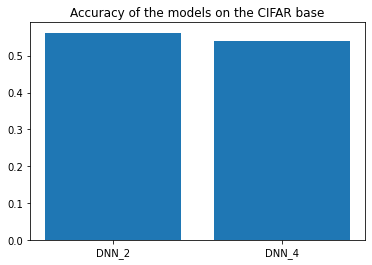

In [168]:
names = ['DNN_2', 'DNN_4']
values = [accurDNN2CIFAR, accurDNN4CIFAR]

plt.bar(names, values)
plt.title("Accuracy of the models on the CIFAR base")

In [169]:
from google.colab import files

torch.save(model_dnn_2_CIFAR.state_dict(), "model_dnn_2_CIFAR.pt") # save 
torch.save(model_dnn_4_CIFAR.state_dict(), "model_dnn_4_CIFAR.pt")
#torch.save(model_cnn_CIFAR.state_dict(), "model_cnn_CIFAR.pt")

# To download the files
#files.download('model_dnn_2_CIFAR.pt')
#files.download('model_dnn_4_CIFAR.pt')
#files.download('model_cnn_CIFAR.pt')

In [170]:
# load the models
model_dnn_2_CIFAR.load_state_dict(torch.load("model_dnn_2_CIFAR.pt"))
model_dnn_4_CIFAR.load_state_dict(torch.load("model_dnn_4_CIFAR.pt"))
#model_cnn_CIFAR.load_state_dict(torch.load("model_cnn_CIFAR.pt"))

<All keys matched successfully>

In [171]:
# initialize X as the input and y as the labels // test loader has 100 images / labels
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    break

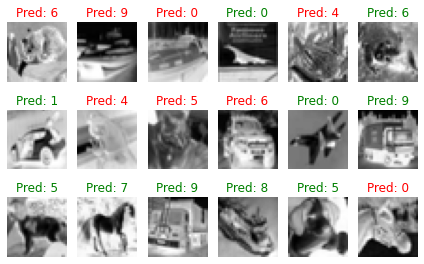

In [172]:
### Illustrate original predictions
yp = model_dnn_2_CIFAR(X)
plot_images(X, y, yp, 3, 6)

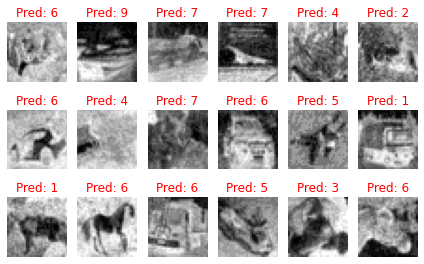

In [173]:
### attacked images FGSM
delta = fgsm(model_dnn_2_CIFAR, X, y, 0.1)
yp = model_dnn_2_CIFAR(X + delta)
plot_images(X+delta, y, yp, 3, 6)

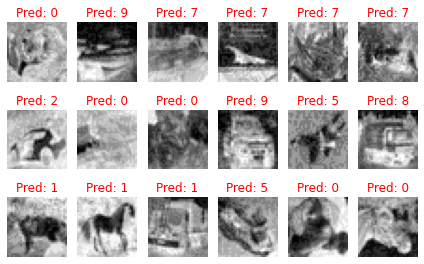

In [174]:
### attacked images PGD
delta = pgd(model_dnn_4_CIFAR, X, y, 0.1, 1e4, 500)
yp = model_dnn_4_CIFAR(X + delta)
plot_images(X+delta, y, yp, 3, 6)

## **Generation of the attacks**

Creation des images attaquees MNIST

In [175]:
# initialise X comme les entrees et y comme les sortie // le test loader ne prend que 100 images / labels
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

images_MNIST = [] # liste qui contiendra tout le set d'images MNIST (avec les images attaquées, les classes associées et les coefs MSCN)

modele = model_dnn_2

# Param fgsm
epsilonFGSM = 0.1

# Param pgd
epsilonPGD = 0.1
alpha = 1e4
num_iter = 1000

# Param DeepFool
num_classes=10
overshoot=0.02
max_iter=50

deltaFGSM = fgsm(modele, X, y, epsilonFGSM)
deltaPGD = pgd(modele, X, y, epsilonPGD, alpha, num_iter)

i = 0
while i < X.size()[0] :
  X[i] = 1-X[i] # L'image qui était codée entre 0 et 1 est maintenant codée entre 1 et 0
  images_MNIST.append(Image())
  images_MNIST[i].original = X[i].view(28,28).cpu().numpy()
  images_MNIST[i].label = int(y[i])

  images_MNIST[i].attack_FGSM = (X+deltaFGSM)[i].view(28,28).cpu().numpy()
  images_MNIST[i].label_FGSM = int(modele(X+deltaFGSM)[1].argmax())

  images_MNIST[i].attack_PGD = (X+deltaPGD)[i].view(28,28).cpu().numpy()
  images_MNIST[i].label_PGD = int(modele(X+deltaPGD)[i].argmax())

  r_tot, loop_i, label, k_i, pert_image = deepfool(X[i],modele,num_classes, overshoot, max_iter)

  images_MNIST[i].attack_DF = pert_image.cpu().view(28,28).numpy()
  images_MNIST[i].label_DF = k_i

  i = i+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Creation des images CIFAR 10

In [176]:
# initialise X comme les entrees et y comme les sortie // le test loader ne prend que 100 images / labels
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    break

images_CIFAR = [] # liste qui contiendra tout le set d'images MNIST (avec les images attaquées, les classes associées et les coefs MSCN)

modele = model_dnn_2_CIFAR

# Param fgsm
epsilonFGSM = 0.1

# Param pgd
epsilonPGD = 0.1
alpha = 1e4
num_iter = 1000

# Param DeepFool
num_classes=10
overshoot=0.02
max_iter=50

deltaFGSM = fgsm(modele, X, y, epsilonFGSM)
deltaPGD = pgd(modele, X, y, epsilonPGD, alpha, num_iter)

i = 0
while i < X.size()[0] :
  X[i] = 1-(X[i]+1)/2 # L'image qui était codée entre -1 et 1 est maintenant codée entre 1 et 0
  images_CIFAR.append(Image())
  images_CIFAR[i].original = X[i].view(32,32).cpu().numpy()
  images_CIFAR[i].label = int(y[i])

  images_CIFAR[i].attack_FGSM = (X+deltaFGSM)[i].view(32,32).cpu().numpy()
  images_CIFAR[i].label_FGSM = int(modele(X+deltaFGSM)[1].argmax())

  images_CIFAR[i].attack_PGD = (X+deltaPGD)[i].view(32,32).cpu().numpy()
  images_CIFAR[i].label_PGD = int(modele(X+deltaPGD)[i].argmax())

  r_tot, loop_i, label, k_i, pert_image = deepfool(X[i],modele,num_classes, overshoot, max_iter)

  images_CIFAR[i].attack_DF = pert_image.cpu().view(32,32).numpy()
  images_CIFAR[i].label_DF = k_i

  i = i+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


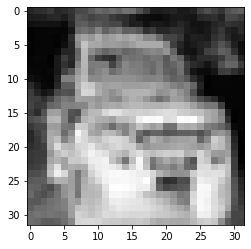

1


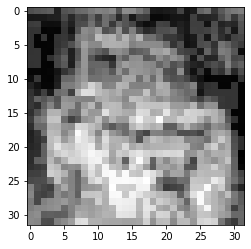

5


In [177]:
i = 9
plt.imshow(images_CIFAR[i].original.reshape(32,32), cmap='gray')
plt.show()
print(images_CIFAR[i].label)
plt.imshow(images_CIFAR[i].attack_PGD.reshape(32,32), cmap='gray')
plt.show()
print(images_CIFAR[i].label_PGD)

# **2. Calculs des coefficients MSCN**

## 2.1 Class `MSCN`

In [178]:
# Python libraries importation
import numpy as np
import scipy.signal as signal # For the convolution product
import scipy.special as special # To calculate the gamme function 
import scipy.optimize as optimize # To solve f(x) = 0 for the function rho_hat (see below)
import matplotlib.pyplot as plt 
import warnings # To ignore errors of type 'RuntimeWarning'
warnings.filterwarnings("ignore", category=RuntimeWarning) 


### Class MSCN

class MSCN:
  """ Class that generates the MSCN coefficients of an image as well as the pairwise products MSCN coefficents 
        - 'image' : the input original image
        - 'kernel_size' : size of the convolution kernel (7 as default)
        - 'kernel_type' : kernel type, "uniform" or "gaussian" ("uniform" as default)
        - 'sigma' : dispersion for a gaussian kernel (7/6 as default) """
  
  def __init__(self, image, kernel_size = 7, kernel_type = 'uniform', **kwargs):
    self.__image = np.array(image) # Conversion d'un éventuel torch.tensor en np.array

    # Creation of the kernel for the convolution
    if kernel_type == 'uniform': # Uniform kernel
      self.__kernel = np.array([1/(kernel_size**2)]*(kernel_size**2)).reshape((kernel_size, kernel_size))

    elif kernel_type == 'gaussian': # Gaussian kernel
      sigma = kwargs.get('sigma', 7/6)
      Y, X = np.indices((kernel_size, kernel_size)) - int(kernel_size/2)
      self.__kernel = 1 / (2 * np.pi * sigma**2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
      self.__kernel /= np.sum(self.__kernel) # "normalization"


  def get_mscn_coefs(self, name='all'):
    """ Returns a dictionnary of the five different MSCN coefficients of the original image, or just one type of coefficients.
        If 'name' is used, then it retured just one type ('mscn', 'horizontal', 'vertical', 'main_diag' or 'sec_diag') """
    # Calculation of the local expectation
    local_mean = signal.convolve2d(self.__image, self.__kernel, 'same') # 'same' : the output has the same size as 'self.__image' 

    # Calculation of the local variance
    local_square_mean = signal.convolve2d(self.__image ** 2, self.__kernel, 'same')
    local_var = np.abs(local_mean ** 2 - local_square_mean) # the absolute value ensures that there is no slightly negative coordinate

    # Calculation of the MSCN coefficients and pairwise products MSCN
    C = 1/255
    coefs = (self.__image - local_mean) / (np.sqrt(local_var) + C)
    
    mscn_coefs = { 'mscn'      : coefs,
                   'horizontal': coefs[:, :-1] * coefs[:, 1:],      # coefs(i,j)*coefs(i,j+1)            j-1 j j+1
                   'vertical'  : coefs[:-1, :] * coefs[1:, :],      # coefs(i,j)*coefs(i+1,j)        i-1  .  .  .
                   'main_diag' : coefs[:-1, :-1] * coefs[1:, 1:],   # coefs(i,j)*coefs(i+1,j+1)       i   .  #  #
                   'sec_diag'  : coefs[1:, :-1] * coefs[:-1, 1:] }  # coefs(i,j)*coefs(i+1,j-1)      i+1  #  #  #
    if name != 'all':
      return mscn_coefs[name]
    return mscn_coefs


  def __aggd_fit(x):
    """ Fit of the asymmetric generalized gaussian distribution features 
        (private function of the class) """
    x = x.ravel() # In order to work on a column (or row) vector

    # Estimation of gamma
    gamma_hat = np.sqrt( 1/(np.sum(x<0)-1) * np.sum(x[x<0]**2) ) / np.sqrt( 1/(np.sum(x>=0)-1) * np.sum(x[x>=0]**2) )

    # Estimation de r
    r_hat = 1/len(x) * np.sum(np.abs(x))**2 / np.sum(x**2)

    # Estimation de R
    R_hat = r_hat * ((gamma_hat**3 + 1) * (gamma_hat + 1)) / ((gamma_hat**2 + 1)**2)

    # Approximation of the inverse generalized Gaussian ratio
    rho_hat = lambda x : special.gamma(2/x)**2 / (special.gamma(1/x) * special.gamma(3/x))
    
    # Estimation of alpha with the inverse of rho
    solution = optimize.root(lambda z: rho_hat(z) - R_hat, [0.2]).x  # R_hat = rho_hat(alpha_hat)
    alpha_hat = solution[0]                                # thus: alpha_hat = rho_hat^(-1)(R_hat)

    # Estimation of beta_l and beta_r
    beta_l_hat = np.sqrt(1/(np.sum(x<0)-1) * np.sum(x[x<0]**2)) * np.sqrt(special.gamma(1/alpha_hat) / special.gamma(3/alpha_hat))
    beta_r_hat = np.sqrt(1/(np.sum(x>=0)-1) * np.sum(x[x>=0]**2)) * np.sqrt(special.gamma(1/alpha_hat) / special.gamma(3/alpha_hat))

    # Estimation of the mean value
    mean_hat = (beta_r_hat - beta_l_hat) * (special.gamma(2/alpha_hat) / special.gamma(1/alpha_hat))
    
    return mean_hat, alpha_hat, beta_l_hat, beta_r_hat


  def estimated_features(self, name='all'):
    """ Returns estimations for the five types of MSCN coefficients
        If 'name' is used, then it retured just one type ('mscn', 'horizontal', 'vertical', 'main_diag' or 'sec_diag') """
    mscn_coefs = self.get_mscn_coefs()

    #mean, alpha, beta_l, beta_r = MSCN.__aggd_fit(mscn_coefs['mscn'])
    #beta = (beta_l + beta_r) / 2
    #print(beta_l, beta_r)
    #features = {'mscn': (float(mean), float(alpha), float(beta))} # Dictionnary containing the features
    #del mscn_coefs['mscn']
    
    features = {}

    for name_coefs, coefs in mscn_coefs.items(): # name in ['horizontal', 'diagonal', 'main_diag', 'sec_diag']
      mean, alpha, beta_l, beta_r = MSCN.__aggd_fit(coefs)
      features[name_coefs] = (float(mean), float(alpha), float(beta_l), float(beta_r))
    
    if name != 'all':
      return features[name]
    return features


  def plot_coefs_and_estimated_distributions(self, name):
    """ Plot the coefficients of the image and the associated estimated distributions """
    mscn_coefs = self.get_mscn_coefs()
    features   = self.estimated_features()

    x = np.linspace(-3, 3, 1000) # Abscisses
    y = None                     # Ordonnées
    
    #legend_text = ""
    #if name == 'mscn':
    #  mean, alpha, beta = features['mscn']
    #  y = ggd_pdf(x, mean, alpha, beta)
    #  legend_text = r"GGD($mean=${}, $\alpha=${}, $\beta=${})".format(round(mean,3), round(alpha,3), round(beta,3))
    #else:
    mean, alpha, beta_l, beta_r = features[name]
    y = aggd_pdf(x, alpha, beta_l, beta_r)
    legend_text = r"AGGD($\alpha=${}, $\beta_l=${}, $\beta_r=${})".format(round(alpha,3), round(beta_l,3), round(beta_r,3))
    
    fig = plt.figure(figsize=(12,6))
    plot_histogram(mscn_coefs[name], name)
    plt.plot(x, 1/np.max(y) * y, label=legend_text) # Plot de la courbe normalisée
    plt.legend()
    plt.show()


### Probability density function (pdf) of the GGD and AGGD distributions

def ggd_pdf(x, mean, alpha, beta):
  """ PDF of the Generalized Gaussian Distribution """
  return alpha/(2 * beta * special.gamma(1/alpha)) * np.exp(-(np.abs(x-mean) / beta)**alpha)

def aggd_pdf(x, alpha, beta_l, beta_r):
  """ PDF of the Asymmetric Generalized Gaussian Distribution """
  return alpha/((beta_l + beta_r) * special.gamma(1/alpha)) * np.where(x < 0, np.exp(-(-x/beta_l)**alpha), np.exp(-(x/beta_r)**alpha))
                                                              # when x < 0, the first expression is used, otherwise the second is used


### Plot function

def plot_histogram(x, label, nbins=50):
  """ Histogramm plot """
  n, bins = np.histogram(x, bins=nbins) # 50 intervals, thus 'bins' will contain 51 "poles"
  n = n / np.max(n)
  bins = (bins[:-1] + bins[1:])/2
  plt.plot(bins, n, label=label, marker='o')

## 2.2 Calculations

0.007336259
0.87752414


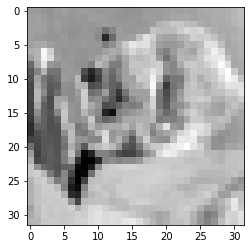

In [179]:
print(np.min(images_CIFAR[0].original))
print(np.max(images_CIFAR[0].original))

plt.imshow(images_CIFAR[0].original, cmap='gray')

In [180]:
kernel_size = 5
kernel_type = 'gaussian'

#############################
# IMAGES MNIST

for i in range(len(images_MNIST)): # Pour toutes les images de l'ensemble, on calcule les coefs MSCN
  original_mscn = MSCN( images_MNIST[i].original, kernel_size, kernel_type )
  images_MNIST[i].coefs_original = original_mscn.get_mscn_coefs()
  images_MNIST[i].features_original = original_mscn.estimated_features()

  image_FGSM_mscn = MSCN( images_MNIST[i].attack_FGSM, kernel_size, kernel_type )
  images_MNIST[i].coefs_FGSM = image_FGSM_mscn.get_mscn_coefs()

  image_PGD_mscn = MSCN( images_MNIST[i].attack_PGD, kernel_size, kernel_type )
  images_MNIST[i].coefs_PGD = image_PGD_mscn.get_mscn_coefs()

  image_DF_mscn = MSCN( images_MNIST[i].attack_DF, kernel_size, kernel_type )
  images_MNIST[i].coefs_DF = image_DF_mscn.get_mscn_coefs()

  #image_CW_mscn = MSCN( images_MNIST[i].attack_CW, kernel_size, kernel_type )
  #images_MNIST[i].coefs_CW = image_CW_mscn.get_mscn_coefs()


#############################
# IMAGES CIFAR10

for i in range(len(images_CIFAR)): # Pour toutes les images de l'ensemble, on calcule les coefs MSCN
  original_mscn = MSCN( images_CIFAR[i].original, kernel_size, kernel_type )
  images_CIFAR[i].coefs_original = original_mscn.get_mscn_coefs()
  images_CIFAR[i].features_original = original_mscn.estimated_features()

  image_FGSM_mscn = MSCN( images_CIFAR[i].attack_FGSM, kernel_size, kernel_type )
  images_CIFAR[i].coefs_FGSM = image_FGSM_mscn.get_mscn_coefs()

  image_PGD_mscn = MSCN( images_CIFAR[i].attack_PGD, kernel_size, kernel_type )
  images_CIFAR[i].coefs_PGD = image_PGD_mscn.get_mscn_coefs()

  image_DF_mscn = MSCN( images_CIFAR[i].attack_DF, kernel_size, kernel_type )
  images_CIFAR[i].coefs_DF = image_DF_mscn.get_mscn_coefs()

  #image_CW_mscn = MSCN( images_CIFAR[i].attack_CW, kernel_size, kernel_type )
  #images_CIFAR[i].coefs_CW = image_CW_mscn.get_mscn_coefs()

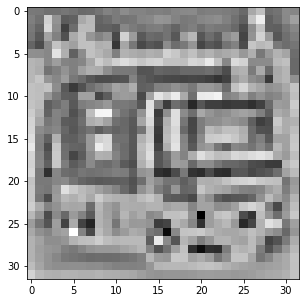

In [181]:
image = images_CIFAR[11] # images_CIFAR[0]

fig = plt.figure(figsize=(12,5))
plt.imshow(image.coefs_original['mscn'], cmap="gray") # Affichage de l'image normalisée
plt.show()

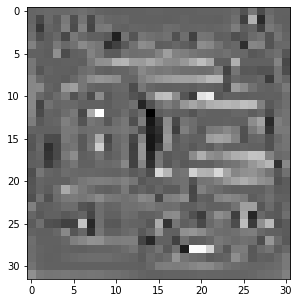

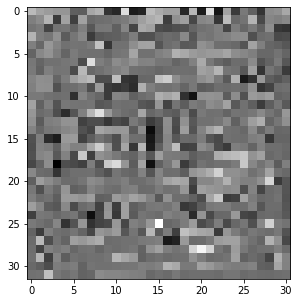

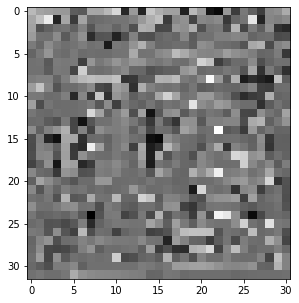

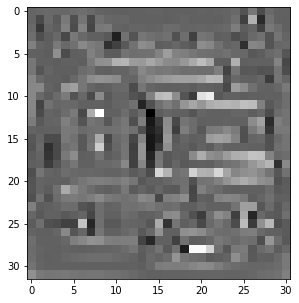

0.0018382072
0.96067786


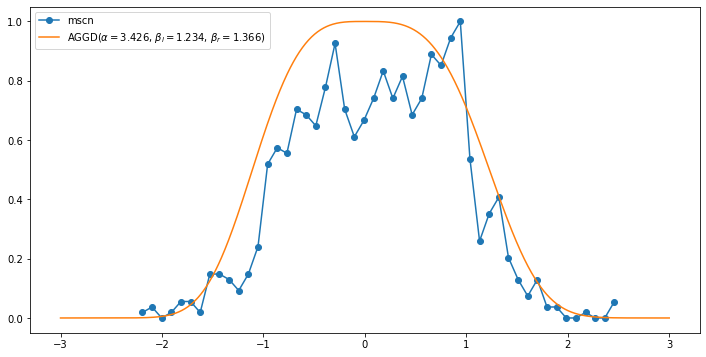

mscn : (0.019811127206235898, 3.050317763239703, 0.9580457194420969, 0.9973450034715367)




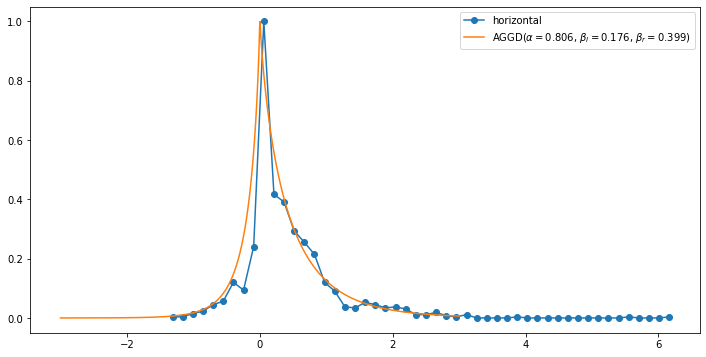

horizontal : (0.1017397238490931, 0.8019645851159081, 0.13902136760285458, 0.20873963455606256)




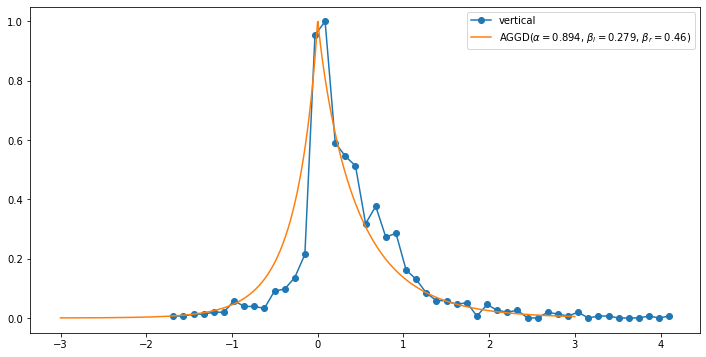

vertical : (0.06138167985070857, 0.8852506676424168, 0.18507016220577846, 0.23572916354492815)




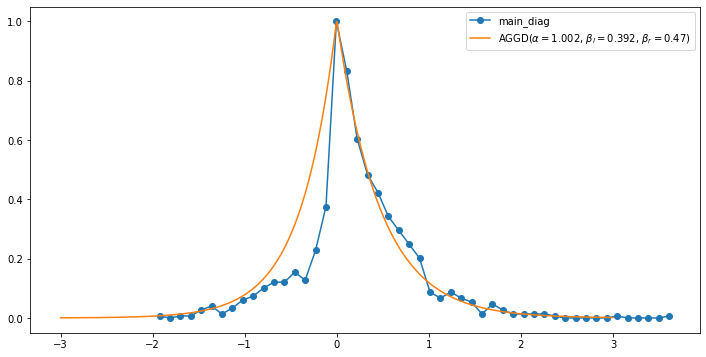

main_diag : (-0.06642905917948139, 0.9406466354997938, 0.2538857312468708, 0.19327136308627857)




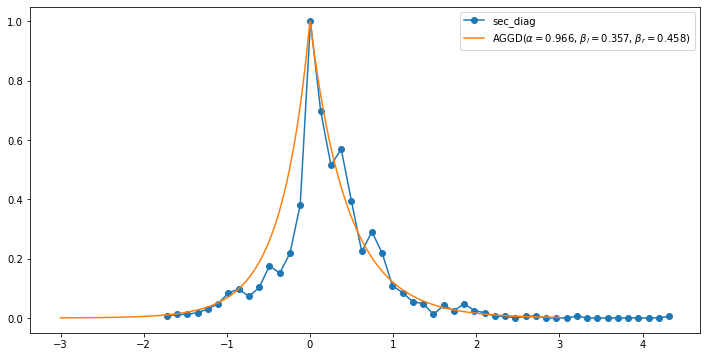

sec_diag : (-0.06787910131475479, 0.9150358020630914, 0.24388315532974916, 0.18463738388001846)




In [182]:
## Test sur une image pour voir les coefs et leurs distributions

image = images_CIFAR[11] # images_CIFAR[0]

fig = plt.figure(figsize=(12,5))
plt.imshow(image.coefs_original['horizontal'], cmap="gray") # Affichage de l'image normalisée
plt.show()
fig = plt.figure(figsize=(12,5))
plt.imshow(image.coefs_FGSM['horizontal'], cmap="gray")
plt.show()
fig = plt.figure(figsize=(12,5))
plt.imshow(image.coefs_PGD['horizontal'], cmap="gray")
plt.show()
fig = plt.figure(figsize=(12,5))
plt.imshow(image.coefs_DF['horizontal'], cmap="gray")
plt.show()
print(np.min(image.original))
print(np.max(image.original))

image_mscn = MSCN(image.original, 7, 'uniform')

# Pour les cinq types de coefficients, affichage du graphe ainsi que des estimations des coefficients
estimations = image.features_original
for name in estimations.keys():
  image_mscn.plot_coefs_and_estimated_distributions(name)
  print('{} : {}'.format(name, estimations[name]), end='\n\n\n')

### To get some training attacked images for statistical testing :

In [ ]:
def truc_pour_theo(np_truc):
  print("[", end="")
  for ligne in np_truc:
    for n in ligne:
      print(n, end=", ")
  print("")


In [ ]:
i = 0
image_test = images_CIFAR[i] # images_MNIST[i]
print(image_test.features_original['mscn'])
print("image_"+str(i+1)+"_original = ", end="")
truc_pour_theo(image_test.coefs_original['mscn'])
_ = plt.imshow(image_test.coefs_original['mscn'], cmap='gray')
print("image_"+str(i+1)+"_attack_FGSM = ", end="")
truc_pour_theo(image_test.coefs_FGSM['mscn'])
print("image_"+str(i+1)+"_attack_PGD = ", end="")
truc_pour_theo(image_test.coefs_PGD['mscn'])
print("image_"+str(i+1)+"_attack_DF = ", end="")
truc_pour_theo(image_test.coefs_DF['mscn'])
print("")

In [ ]:
mean_3, var_3 =  0.01095024629140401, 0.18353156300294676
image_3_original = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.12168889425466634, -0.16018296546010846, -0.20455123823616028, -0.20455123823616028, -0.20455123823616028, -0.20455123823616028, -0.20455123823616028, -0.186207024817132, -0.135542780309449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17813983639327116, -0.24626734823081667, -0.3061002351084084, -0.3061002351084084, -0.3061002351084084, -0.3061002351084084, -0.3061002351084084, -0.2642947543989392, -0.19400671514093812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2213447006270787, -0.3226129940792665, -0.3743517827606634, -0.3743517827606634, -0.3743517827606634, -0.3743517827606634, -0.3743517827606634, -0.3051378339712111, -0.19400671514093812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.12473350602143017, -0.26632398437911803, -0.4036915575656601, -0.4512956101857766, 0.06202903720318076, 2.97987426352909, 1.0211355706435912, -0.4381128253753856, -0.33965408354861315, -0.19400671514093812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.18337728327452582, -0.32752233571238065, -0.4730781890817655, -0.5190832825570014, 0.5667126281056197, 2.6259806495003435, 0.5043105697253567, -0.4852046960627923, -0.35837537427358157, -0.19400671514093812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.20989132996093643, -0.39750257328342853, -0.5393610685957275, -0.58443455492382, 0.9782310616982584, 2.2052128151265347, -0.58443455492382, -0.5198676078277525, -0.3621483650553475, -0.19400671514093812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1182109509879725, -0.2630270422643556, -0.4703066751535606, -0.6091425396516824, -0.1694099048279689, 1.9731530232918497, 0.9610881805464119, -0.6446906031388813, -0.5511174532074405, -0.3621483650553475, -0.19400671514093812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.171824878120526, -0.329185939703951, -0.5434968825775167, -0.6522669844704745, 0.2150096018138481, 2.011428657647459, -0.006901017669105182, -0.6409849572301434, -0.5178075554571805, -0.29751286382829617, -0.1328768695733042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21807001637680293, -0.39479862708732794, -0.5993024369669071, -0.6788718188856185, 1.4415047274808361, 1.6619398964078687, -0.563405768047545, -0.6192643388231729, -0.465485826259571, -0.2288282214764759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1284051033229115, -0.27215143325287466, -0.47562840367444836, -0.6512519413848836, -0.36774490128219706, 1.9419139457616157, 1.5465669562077835, -0.6852381888320165, -0.5949387311761639, -0.40710097416016894, -0.19173879616585304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.18338200878478017, -0.33897954992301216, -0.5499537837041815, -0.6954903627898426, 0.26272183349849737, 1.9002143838628103, 1.2925913910715698, -0.6733100912204937, -0.5536689269004629, -0.34069738084368506, -0.15086237096293376, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.22864866326417013, -0.4049403376891793, -0.6093752967822276, -0.7264025788172968, 0.696549904780999, 1.8580207097295096, 0.05468438251379571, -0.6566037846451946, -0.5070652954094452, -0.2841051308823194, -0.08785224302634607, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.11148433597503146, -0.27593920392800575, -0.47671777186707964, -0.6472588246828136, -0.15554116242346167, 1.6687580615302386, 1.344438220033181, -0.6452239037498779, -0.6220338744552693, -0.43980792768149335, -0.2364538943574801, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.161173812994639, -0.3431033839728657, -0.5533936305772159, -0.6945417393110874, 0.5240775980374844, 1.8696992549525768, 0.9452264145194371, -0.7150961670537703, -0.5813980507669266, -0.37388843190806714, -0.18783196139635047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21420666676987213, -0.4078788730571596, -0.617951764216161, -0.7310577668904341, 1.0112169874256303, 1.868012628432789, 0.08216139463114679, -0.6891649490135796, -0.5266688422951944, -0.30297997154584194, -0.14549975427009354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2514482876369737, -0.4708179239406846, -0.6678421539997556, -0.5093927521156083, 1.5910616033517146, 1.4192055046550816, -0.7542688383948473, -0.6584812486845399, -0.4660391471376433, -0.23884475960054133, -0.07660955019412423, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.12934131170934698, -0.31050594433828194, -0.5328507183931651, -0.7158161980303925, 0.4263099245572205, 1.7598739975011524, 0.8144368352270015, -0.7512423444956259, -0.625667990616269, -0.4177358395572692, -0.18750967771480911, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.18276173952548302, -0.37766701225835725, -0.5964123110236326, -0.75156282405926, 0.7158368106113451, 1.7309612587376262, 0.6271366161148739, -0.7264907265498182, -0.5721562786411212, -0.3553467906922438, -0.13274674461014108, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.08454369585117849, -0.23079373728489783, -0.4459418532883882, -0.6565604193120542, -0.7832662386489648, 1.441098371838741, 1.6947539684059423, -0.1371780140837679, -0.7017578343969461, -0.5180561149197653, -0.30010705113719705, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1192260270604514, -0.27701422567568507, -0.5037870540938267, -0.6847040784135089, -0.1748151748130847, 1.711081926282051, 1.740859247144378, -0.12187227348435459, -0.6650811736739287, -0.45764475117588904, -0.26934771147810826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1192260270604514, -0.27701422567568507, -0.4777438568407953, -0.6285328507433822, 0.7473673494769274, 1.9000616209322305, 1.400220742159577, -0.6558880338045064, -0.5800072454536045, -0.3948114301516556, -0.22968597800191923, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1192260270604514, -0.27701422567568507, -0.4482776430512249, -0.46384533675068607, 1.6892577751797202, 2.105098478559705, 0.6869749731812959, -0.5988337772980197, -0.4934789280038677, -0.3288582141415685, -0.19604642651473186, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1192260270604514, -0.27701422567568507, -0.41540049322905304, -0.4503399735315502, 1.7675563654118605, 1.5127521915006528, -0.4098612857732266, -0.5212472847376561, -0.4126787215206638, -0.26995380379085576, -0.1362826244087478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1192260270604514, -0.252936062768311, -0.3652189459904275, -0.4305201555587763, -0.4314790805079708, -0.4314790805079708, -0.4314790805079708, -0.42675634830687653, -0.3254349784251231, -0.2015323913706516, -0.04298942183520894, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1192260270604514, -0.2086543541863975, -0.2957388868784185, -0.3314112908891657, -0.3314112908891657, -0.3314112908891657, -0.3314112908891657, -0.3259512297940669, -0.2434504366423358, -0.14740119748223074, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.05977928461132924, -0.14290743748913237, -0.2032607339809429, -0.20870952632310472, -0.20870952632310472, -0.20870952632310472, -0.20870952632310472, -0.20594653248909783, -0.14658498004468395, -0.08454369585117849, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
image_3_attack_FGSM = [1.8789827271147623, -1.2738037745118451, -1.1231422277067002, 1.6502364286738178, -1.000963079687398, 1.6502364286738178, -1.1176697493159518, -1.1614259579127328, -1.2576328137594381, 1.1176697493159518, -1.4295775863343565, -1.367901683763885, 1.2079761365852881, -1.2079761365852881, -1.2079761365852881, -1.1614259579127328, 1.496540156054124, -1.076458708740686, -1.1176697493159518, -1.2079761365852881, 1.3107826162946743, -1.2079761365852881, -1.1614259579127328, 1.367901683763885, -1.2079761365852881, 1.410552125386471, -1.4172605715489952, -1.5745367650226842, -1.3171536933006525, 1.622620975062087, 1.59119978505158, -0.8729224688743469, 1.5793855580193108, -0.8729224688743469, 1.2549040302873937, 1.2029985486808201, 1.0641910238330334, 0.908080744553059, -1.4338117019258823, 0.9446363884898751, 1.0225143950489877, -1.1541750819918937, -0.6757195847409991, -0.6495861094680971, 0.4419825212503113, 0.462302503078861, 0.4419825212503112, 0.4017294517092806, -0.6089496776967203, -0.8475907357434963, 1.3103021915326003, -1.0225143950489877, 1.2029985486808201, -1.1688649544465082, -1.3005563972400072, 1.4747255696819181, 1.5412441698921147, -1.0016673791358435, -0.8429763960708356, -0.7765272652277353, -0.7765272652277353, -0.810144670608289, -0.9948638291311558, 1.0362309827340175, -1.2238115948497847, 0.7116147774408881, 0.7116147774408881, 0.7437199585955934, 0.8446885586706416, -1.1426478042783068, -0.6500525840567518, -0.6490002739400138, -0.5753025724565743, -0.5401097435573224, -0.5401097435573224, -0.5753025724565743, -0.5357995319759998, 0.8708118003842545, -0.810144670608289, 1.2238115948497847, 1.1250250138048021, -1.0712513577888343, 1.2170239774920402, 1.2999205861404735, -1.1614259579127328, -0.9446363884898751, -0.810144670608289, -0.7650352297039356, -0.7985953038372974, -0.8330194267365412, -1.0230250145334043, -1.065807703850978, -1.3177079303986556, 0.5446600253960298, 0.5446600253960298, 0.5753716369928502, 0.6683644398682075, 0.45064670947627683, 0.0036443259153888037, -0.6838965552275426, -0.617724907352503, 0.08744847844123117, 0.10056080869723273, 0.08744847844123117, -0.5048379643034732, 0.9185509740354635, 1.3785016572281774, -0.7322190238111655, -0.8330194267365412, -0.9552099173814359, 1.154146608308272, -1.3107826162946743, 1.3107826162946743, -0.9827266436494504, -0.8446885586706416, 1.1106925689820548, -0.9049836667026269, -0.9820989975745814, 0.7985953038372974, -1.2610438743414514, 0.5446600253960298, 0.3865862690429518, 0.3865862690429518, 0.45147970421960815, 0.4755533414575495, 0.14538361205718064, -0.796435163416213, -0.7842773438611438, -0.25838094690953034, 2.9537697859524004, 1.2458812878092225, -0.644449458374461, -0.566052561534037, -0.7071711370844501, -0.7322190238111655, -0.8330194267365412, 0.9428150376715982, 0.9948638291311558, 1.0641910238330334, -1.4295775863343565, -1.2576328137594381, 1.2549040302873937, -0.9170746185448575, 1.0230250145334043, -0.9428150376715982, -1.065807703850978, 0.7322190238111655, 0.6683644398682075, 0.48287711519666365, 0.3524609283593344, 0.3524609283593344, 0.41947286905213155, 0.37153113211136385, -0.007702054885470768, -0.21633471742725524, -0.8037288411521062, 0.2679844347174256, 2.720508165524129, 0.24303037665945007, -0.6601368996101847, -0.5842307265533422, -0.7373408932828676, -0.7985953038372974, -0.9428150376715982, -1.065807703850978, 0.9552099173814359, 1.0225143950489877, 1.1176697493159518, -1.367901683763885, 1.1079807439759413, 0.9948638291311558, 0.8330194267365412, -1.2079503626904242, 0.6683644398682075, 0.5753716369928502, 0.5753716369928502, 0.45147970421960815, 0.3524609283593344, 0.3865862690429518, 0.45147970421960815, 0.20127503059317853, -0.11286394905748857, -0.2972266079935755, -0.3136017717134191, 1.2343090199486881, 2.3980300629114617, -0.7906761052964147, -0.18621551065531367, -0.651952282978037, -0.8323492369612027, -0.8684359068415377, -0.9428150376715982, -0.9820989975745814, -1.0362309827340175, 1.154146608308272, 1.2576328137594381, 1.000963079687398, -1.4338117019258823, 0.7765272652277353, 0.6061464511927777, -1.6793684116377574, 0.45147970421960815, 0.3865862690429518, 0.41947286905213155, 0.3165923097361754, 0.27821842396074375, 0.3865862690429518, 0.5013504614414561, 0.08887487321685834, -0.19738135520617586, -0.8914325929642385, 0.12048382404237624, 1.6935319490213105, 1.2482093797012754, -0.3230912057406238, -0.7884953694091441, -0.6686022863757808, 0.6060810374128847, 0.9049836667026269, 0.8684359068415377, 0.8684359068415377, 0.9552099173814359, 1.0641910238330334, -1.3107826162946743, 0.9664656890147624, -1.579385558019311, 0.6801107236998101, 0.5138786188139034, 0.41947286905213155, 0.3165923097361754, 0.27821842396074375, 0.3165923097361754, 0.23606943501559582, 0.23606943501559582, 0.3865862690429518, 0.43217603837710056, -0.03722960208696783, -0.9582014942570356, -0.9365466026381952, -0.005048749887277485, 1.8203903770519458, -0.21818548279120195, -0.903761924584249, -0.8254452315541919, 0.07128315964666819, 0.68454212750351, 0.7650352297039356, 0.7650352297039356, 0.7650352297039356, -1.2238115948497847, -1.2549040302873937, 1.2079761365852881, -1.9536718743752468, 0.7443897040475053, 0.5582922751132529, 0.3865862690429518, 0.3165923097361754, 0.18768512880909233, 0.18768512880909233, 0.23606943501559582, 0.18768512880909233, 0.27821842396074375, -2.006576463198257, -1.4458714146164313, -0.11006547186746556, -0.9566631124045656, -0.9260742705981414, 1.2930872297352336, 1.5200723397991318, -0.8230792346445197, -0.38554694664174904, -0.21182668229443347, 0.12419310468478384, 0.5446600253960298, 0.6061464511927777, 0.6371059575633514, -1.3785016572281774, -1.3356439164082599, -1.3103021915326003, -1.3107826162946743, 0.9340991462305289, 0.7443897040475053, 0.5582922751132529, 0.3865862690429518, 0.3165923097361754, 0.23606943501559582, 0.27821842396074375, 0.27821842396074375, 0.27821842396074375, 0.3865862690429518, 0.5373057719002498, 0.22683316566685383, -0.872903782006776, -0.9338065241053118, -0.5358786837767553, 1.8963599938652385, 1.4814416741333825, -0.9588634125567038, -0.3707791950752256, -0.1642496156893152, 0.21890996578821503, 0.3524609283593344, 0.41947286905213155, 0.45147970421960815, 0.5446600253960298, 0.7116147774408881, -1.4338117019258823, -1.367901683763885, 0.9664656890147624, -1.7562750689447164, 0.5882829837973503, 0.41947286905213155, 0.3165923097361754, 0.3165923097361754, 0.3524609283593344, 0.3524609283593344, 0.3524609283593344, 0.45147970421960815, 0.4770259036071865, 0.08978307112618925, -0.24158352250161583, -0.9556300594623045, 0.15454926712647585, 1.9003622010327061, 1.251159180206198, -0.9852958053014667, -0.9860889017553353, -0.08575612626540795, 0.401167133813562, 0.27821842396074375, 0.3865862690429518, 0.45147970421960815, 0.5446600253960298, -1.5380061318883702, 0.908080744553059, 1.1614259579127328, 1.0376016629661278, 0.8390485776977593, 0.6491127582450472, 0.4828771151966637, 0.3524609283593344, 0.3524609283593344, 0.3865862690429518, 0.3865862690429518, 0.3865862690429518, 0.5138786188139034, 0.34324717006885913, -0.029116605195138347, -0.912963844807885, -0.9748469469121608, 0.6197904925571777, 1.8611489389897808, -0.11503638378367073, -1.0222503277411306, -0.3120523042026516, -0.02964315579948458, 0.35041637419653615, 0.23606943501559582, 0.3865862690429518, 0.45147970421960815, 0.5753716369928502, -1.4649029487488954, 0.9446363884898751, 1.2079761365852881, -1.4295775863343565, 0.908080744553059, 0.7116147774408881, -1.6793684116377574, 0.45147970421960815, 0.41947286905213155, 0.41947286905213155, 0.3524609283593344, -2.786012325678339, -1.9808146998729548, 0.10043892097900908, -0.19470261146359782, -1.0129589394972527, -0.4050869437331995, 1.6600045395143865, 1.3046750350354357, -0.9421838374285784, -1.043337051219855, -0.25528595544486865, 0.03452850761562051, 0.3524609283593344, 0.23606943501559582, 0.3524609283593344, 0.3865862690429518, 0.4828771151966637, 0.6491127582450472, 0.8390485776977591, -1.5697050798718342, -1.2576328137594381, 1.0641910238330334, -1.2778621785017397, 0.6683644398682075, -1.6793684116377574, 0.4828771151966637, 0.45147970421960815, 0.3865862690429518, -2.786012325678339, -1.6597573354423165, -0.0831696377246878, -0.32933834169509907, -0.4950337923388808, 0.3348890033587327, 1.8751026953215155, 0.8391412099077482, -1.0874362295372848, -0.40767719254603735, -0.18820591937564862, 0.12629006288459424, 0.3165923097361754, 0.23606943501559582, 0.3524609283593344, 0.3524609283593344, 0.45147970421960815, -1.8061115587112382, 0.8063706363360363, 1.000963079687398, -1.2079761365852881, -1.154146608308272, -1.2238115948497847, 0.7000323380242861, 0.5446600253960298, 0.5138786188139034, 0.4828771151966637, 0.3865862690429518, 0.3165923097361754, -1.3716338212264894, -0.20655063251157232, -0.42122066145067716, -1.1417770596880377, 0.8388969868135228, 1.7941736896030465, -0.18258872640381182, -1.1261700936489576, -0.3713336605587688, -0.10471284821382791, 0.3098492495056628, 0.27821842396074375, 0.27821842396074375, 0.41947286905213155, 0.45147970421960815, -1.6793684116377574, -1.5380061318883702, 0.908080744553059, -1.4295775863343565, 1.367901683763885, -1.0641910238330334, -1.1250250138048021, -1.2079503626904242, 0.5753716369928502, 0.5446600253960298, 0.5138786188139034, 0.41947286905213155, 0.3165923097361754, -0.07084644080104067, -0.32262288462701305, -0.5140602903126361, -0.3382582045403387, 1.4514362096800977, 1.2566954487205588, -0.5450733719856211, -0.4695145265873365, -0.2646776514240122, 0.11382170730382453, 0.5128850573354129, 0.45147970421960815, 0.4828771151966637, 0.5753716369928502, -1.5933368409032767, 0.7000323380242861, 0.8446885586706416, 1.0225143950489877, 1.2079761365852881, -1.2079761365852881, -1.0641910238330334, -1.1250250138048021, 0.7985953038372974, -1.444106837143596, 0.6061464511927777, 0.5753716369928502, 0.5446600253960298, 0.3186533242192919, -0.11596584320606468, -0.3906990511826369, -0.574622818803, 0.6778602156203456, 1.5863059689717405, 0.5570105000892993, -0.5589577824925565, -0.4210763323689123, -0.14390427516718254, 0.37699085772804225, 0.6683644398682075, 0.6371059575633514, 0.7000323380242861, 0.7985953038372974, 0.7985953038372974, 0.9049836667026269, 1.0362309827340175, 1.2029985486808201, -1.1614259579127328, -1.2576328137594381, 1.154146608308272, 0.9552099173814359, -1.1106925689820548, 0.7322190238111655, 0.6683644398682075, 0.6683644398682075, 0.6683644398682075, 0.25064902915308945, -0.16217081393786892, -0.4376544243952142, -0.5837687644506815, 0.9290449537233172, 1.988441311100726, 0.3195949930910924, -0.520582454579502, -0.3380622774418085, 0.031988246722111154, 0.6863266232139715, 0.8330194267365412, -1.1106925689820548, 0.9049836667026269, 0.9820989975745814, 0.9820989975745814, -0.8330194267365412, -0.8802855331375646, -0.9446363884898751, -1.0376016629661278, -1.367901683763885, 1.1079807439759413, 0.9552099173814359, 0.8684359068415377, -1.1106925689820548, 0.8330194267365412, 0.8684359068415377, 0.8668560518911611, 0.18629120442767383, -0.21298105038079876, -0.4770055035214193, -0.6029755609047696, 1.6060755300149383, 1.3612791619578777, 0.004836444999122113, -0.5145060919127958, -0.8504767734385223, -0.8956696138500294, -1.065807703850978, -0.9428150376715982, 1.0230250145334043, -0.8684359068415377, -0.8330194267365412, -0.8330194267365412, -0.7650352297039356, -0.8446885586706416, 1.4338117019258823, -1.000963079687398, -1.367901683763885, 1.154146608308272, 1.0362309827340175, 0.9820989975745814, -0.9820989975745814, 0.9820989975745814, -0.8684359068415377, -0.8517423490446817, -0.7046570034673, -0.7699501309340787, -0.9152388732703567, 0.020389765098406752, 1.3335741360897582, 1.867860981490677, 0.03211556543318865, -0.4375496718373603, -0.7568975861246401, -0.8509096841333789, -0.9049836667026269, -0.7985953038372974, -0.7985953038372974, -0.7650352297039356, -0.7322190238111655, -0.7322190238111655, -0.6683644398682075, -0.7437199585955934, -0.8063706363360363, -0.8761730587971237, 1.1176697493159518, -1.154146608308272, 1.0362309827340175, 0.9820989975745814, -0.9428150376715982, -0.9049836667026269, -0.7985953038372974, -0.8167960686777013, -0.6835577448856147, -0.7524516854933835, -0.8748529150536141, 0.8737566643741825, 1.974035297017186, 1.4963762057421512, -1.0066349858576342, -0.363578155292351, -0.07958075709259621, -0.8929954740475055, -0.8684359068415377, -0.7650352297039356, -0.7650352297039356, -0.7322190238111655, -0.6683644398682075, 1.444106837143596, -0.6061464511927777, -0.7116147774408881, -0.7748272362991399, -0.8511738748670622, 1.076458708740686, 1.1079807439759413, 1.079533091184871, -0.8684359068415377, -0.7985953038372974, -0.7322190238111655, -0.6371059575633514, -0.6225244453068145, -0.5838310097072876, -0.6751688300521322, -0.6992426658740296, 1.7665967546741024, 2.1742934296508776, 0.7966824240331426, -0.4545510418278222, -0.28146302719539334, 0.012323996679118508, -0.9777891338450229, -0.9049836667026269, -0.7985953038372974, -0.7650352297039356, -0.7322190238111655, 1.3785016572281774, 1.444106837143596, -0.5753716369928502, -0.6801107236998101, -0.7443897040475053, -0.8511738748670622, -1.3107826162946743, 1.2549040302873937, -0.8446885586706416, -0.7000323380242861, -0.6061464511927777, -0.5753716369928502, -0.5138786188139034, -0.4992905670695073, 0.34101382578975425, -0.6207854058151211, -0.6839113870546789, 1.8235619205509648, 1.0335312967178016, -0.8375286004187724, -0.37471796297409876, -0.20405317332170503, 0.07135018806457302, -1.1004130625808868, -1.065807703850978, -0.9820989975745814, -0.9428150376715982, 0.9820989975745814, 1.065807703850978, 1.157963190564081, -0.7322190238111655, -0.810144670608289, -0.8390485776977591, -0.9039377329198908, 1.3107826162946743, -0.9827266436494504, 1.3356439164082599, -0.6683644398682075, -0.6061464511927777, -0.6061464511927777, 1.6793684116377574, 1.6746827179235348, 0.3513122046415988, 0.031130844516021782, -0.11075102965388488, -0.1371373683945692, -0.19044441104261264, -0.2471386242676753, -0.2573002225133335, -0.07492284727723432, 0.21910243232464896, 0.7648391059070151, 0.7985953038372974, 0.8684359068415377, 0.8684359068415377, -1.0230250145334043, 0.9428150376715982, 1.0230250145334043, 1.1106925689820548, -0.9170746185448575, -0.9446363884898751, 1.7396382402265715, 1.4730265750068494, 1.4460312256201182, -0.8773844949860633, 1.4649029487488954, -0.7116147774408881, -0.7116147774408881, -0.6801107236998101, -0.730657444469222, -0.5681379555394866, -0.6180547479113879, 0.03180619786634928, 0.001645177893291552, -0.044953138334442824, -0.09359401607947719, -0.10523009184394749, 0.09059477597896462, 0.4518339160799807, 0.7765272652277353, 0.810144670608289, 0.8446885586706416, 0.8446885586706416, 0.8802855331375646, 0.9170746185448575, -1.079533091184871, -0.9948638291311558, -1.0712513577888343, -1.0806800040739348, -1.1231422277067002, -1.3171536933006525, -1.119048948318681, -0.9651539679821062, -0.8390485776977591, -0.8390485776977593, -0.8729224688743469, -0.8729224688743469, -0.9163543797681428, 0.5846465803343215, 0.39216103155956067, -0.8603622969262961, 0.3008790637311152, 0.2563517230048769, 0.2109555661660019, -1.0551949238755483, 0.48328412543761007, 0.8085567977465821, -1.579385558019311, 0.8390485776977593, 0.8729224688743469, 0.8729224688743469, 0.908080744553059, 0.9446363884898751, 1.0225143950489877, 1.1079807439759413, 1.2170239774920402, 1.4133215006098323, -1.3171536933006525, -1.5185064378537945, -1.3171536933006525, 1.6161852928345266, -1.0376016629661278, 1.5697050798718342, 1.496540156054124, -1.076458708740686, 1.4295775863343565, -1.2576328137594381, -1.367901683763885, -1.5697050798718342, 1.0376016629661278, -1.7396382402265715, 0.9340991462305289, -1.9536718743752468, 0.9340991462305289, -1.9536718743752468, 0.9340991462305289, -1.8398922577267987, 0.9664656890147624, -1.7396382402265715, -1.6502364286738178, -1.5697050798718342, 1.1176697493159518, -1.3107826162946743, 1.2999205861404735, 1.4747255696819181, -1.5745367650226842]
image_3_attack_PGD = [1.8789827271147623, -1.2738037745118451, -1.1231422277067002, 1.6502364286738178, -1.000963079687398, 1.6502364286738178, -1.1176697493159518, -1.1614259579127328, -1.2576328137594381, 1.1176697493159518, -1.4295775863343565, -1.367901683763885, 1.2079761365852881, -1.2079761365852881, -1.2079761365852881, -1.1614259579127328, 1.496540156054124, -1.076458708740686, -1.1176697493159518, -1.2079761365852881, 1.3107826162946743, -1.2079761365852881, -1.1614259579127328, 1.367901683763885, -1.2079761365852881, 1.410552125386471, -1.4172605715489952, -1.5745367650226842, -1.3171536933006525, 1.622620975062087, 1.59119978505158, -0.8729224688743469, 1.5793855580193108, -0.8729224688743469, 1.2549040302873937, 1.2029985486808201, 1.0641910238330334, 0.908080744553059, -1.4338117019258823, 0.9446363884898751, 1.0225143950489877, -1.1541750819918937, -0.6757195847409991, -0.6495861094680971, 0.4419825212503113, 0.462302503078861, 0.4419825212503112, 0.4017294517092806, -0.6089496776967203, -0.8475907357434963, 1.3103021915326003, -1.0225143950489877, 1.2029985486808201, -1.1688649544465082, -1.3005563972400072, 1.4747255696819181, 1.5412441698921147, -1.0016673791358435, -0.8429763960708356, -0.7765272652277353, -0.7765272652277353, -0.810144670608289, -0.9948638291311558, 1.0362309827340175, -1.2238115948497847, 0.7116147774408881, 0.7116147774408881, 0.7437199585955934, 0.8446885586706416, -1.1426478042783068, -0.6500525840567518, -0.6490002739400138, -0.5753025724565743, -0.5401097435573224, -0.5401097435573224, -0.5753025724565743, -0.5357995319759998, 0.8708118003842545, -0.810144670608289, 1.2238115948497847, 1.1250250138048021, -1.0712513577888343, 1.2170239774920402, 1.2999205861404735, -1.1614259579127328, -0.9446363884898751, -0.810144670608289, -0.7650352297039356, -0.7985953038372974, -0.8330194267365412, -1.0230250145334043, -1.065807703850978, -1.3177079303986556, 0.5446600253960298, 0.5446600253960298, 0.5753716369928502, 0.6683644398682075, 0.45064670947627683, 0.0036443259153888037, -0.6838965552275426, -0.617724907352503, 0.08744847844123117, 0.10056080869723273, 0.08744847844123117, -0.5048379643034732, 0.9185509740354635, 1.3785016572281774, -0.7322190238111655, -0.8330194267365412, -0.9552099173814359, 1.154146608308272, -1.3107826162946743, 1.3107826162946743, -0.9827266436494504, -0.8446885586706416, 1.1106925689820548, -0.9049836667026269, -0.9820989975745814, 0.7985953038372974, -1.2610438743414514, 0.5446600253960298, 0.3865862690429518, 0.3865862690429518, 0.45147970421960815, 0.4755533414575495, 0.14538361205718064, -0.796435163416213, -0.7842773438611438, -0.25838094690953034, 2.9537697859524004, 1.2458812878092225, -0.644449458374461, -0.566052561534037, -0.7071711370844501, -0.7322190238111655, -0.8330194267365412, 0.9428150376715982, 0.9948638291311558, 1.0641910238330334, -1.4295775863343565, -1.2576328137594381, 1.2549040302873937, -0.9170746185448575, 1.0230250145334043, -0.9428150376715982, -1.065807703850978, 0.7322190238111655, 0.6683644398682075, 0.48287711519666365, 0.3524609283593344, 0.3524609283593344, 0.41947286905213155, 0.37153113211136385, -0.007702054885470768, -0.21633471742725524, -0.8037288411521062, 0.2679844347174256, 2.720508165524129, 0.24303037665945007, -0.6601368996101847, -0.5842307265533422, -0.7373408932828676, -0.7985953038372974, -0.9428150376715982, -1.065807703850978, 0.9552099173814359, 1.0225143950489877, 1.1176697493159518, -1.367901683763885, 1.1079807439759413, 0.9948638291311558, 0.8330194267365412, -1.2079503626904242, 0.6683644398682075, 0.5753716369928502, 0.5753716369928502, 0.45147970421960815, 0.3524609283593344, 0.3865862690429518, 0.45147970421960815, 0.20127503059317853, -0.11286394905748857, -0.2972266079935755, -0.3136017717134191, 1.2343090199486881, 2.3980300629114617, -0.7906761052964147, -0.18621551065531367, -0.651952282978037, -0.8323492369612027, -0.8684359068415377, -0.9428150376715982, -0.9820989975745814, -1.0362309827340175, 1.154146608308272, 1.2576328137594381, 1.000963079687398, -1.4338117019258823, 0.7765272652277353, 0.6061464511927777, -1.6793684116377574, 0.45147970421960815, 0.3865862690429518, 0.41947286905213155, 0.3165923097361754, 0.27821842396074375, 0.3865862690429518, 0.5013504614414561, 0.08887487321685834, -0.19738135520617586, -0.8914325929642385, 0.12048382404237624, 1.6935319490213105, 1.2482093797012754, -0.3230912057406238, -0.7884953694091441, -0.6686022863757808, 0.6060810374128847, 0.9049836667026269, 0.8684359068415377, 0.8684359068415377, 0.9552099173814359, 1.0641910238330334, -1.3107826162946743, 0.9664656890147624, -1.579385558019311, 0.6801107236998101, 0.5138786188139034, 0.41947286905213155, 0.3165923097361754, 0.27821842396074375, 0.3165923097361754, 0.23606943501559582, 0.23606943501559582, 0.3865862690429518, 0.43217603837710056, -0.03722960208696783, -0.9582014942570356, -0.9365466026381952, -0.005048749887277485, 1.8203903770519458, -0.21818548279120195, -0.903761924584249, -0.8254452315541919, 0.07128315964666819, 0.68454212750351, 0.7650352297039356, 0.7650352297039356, 0.7650352297039356, -1.2238115948497847, -1.2549040302873937, 1.2079761365852881, -1.9536718743752468, 0.7443897040475053, 0.5582922751132529, 0.3865862690429518, 0.3165923097361754, 0.18768512880909233, 0.18768512880909233, 0.23606943501559582, 0.18768512880909233, 0.27821842396074375, -2.006576463198257, -1.4458714146164313, -0.11006547186746556, -0.9566631124045656, -0.9260742705981414, 1.2930872297352336, 1.5200723397991318, -0.8230792346445197, -0.38554694664174904, -0.21182668229443347, 0.12419310468478384, 0.5446600253960298, 0.6061464511927777, 0.6371059575633514, -1.3785016572281774, -1.3356439164082599, -1.3103021915326003, -1.3107826162946743, 0.9340991462305289, 0.7443897040475053, 0.5582922751132529, 0.3865862690429518, 0.3165923097361754, 0.23606943501559582, 0.27821842396074375, 0.27821842396074375, 0.27821842396074375, 0.3865862690429518, 0.5373057719002498, 0.22683316566685383, -0.872903782006776, -0.9338065241053118, -0.5358786837767553, 1.8963599938652385, 1.4814416741333825, -0.9588634125567038, -0.3707791950752256, -0.1642496156893152, 0.21890996578821503, 0.3524609283593344, 0.41947286905213155, 0.45147970421960815, 0.5446600253960298, 0.7116147774408881, -1.4338117019258823, -1.367901683763885, 0.9664656890147624, -1.7562750689447164, 0.5882829837973503, 0.41947286905213155, 0.3165923097361754, 0.3165923097361754, 0.3524609283593344, 0.3524609283593344, 0.3524609283593344, 0.45147970421960815, 0.4770259036071865, 0.08978307112618925, -0.24158352250161583, -0.9556300594623045, 0.15454926712647585, 1.9003622010327061, 1.251159180206198, -0.9852958053014667, -0.9860889017553353, -0.08575612626540795, 0.401167133813562, 0.27821842396074375, 0.3865862690429518, 0.45147970421960815, 0.5446600253960298, -1.5380061318883702, 0.908080744553059, 1.1614259579127328, 1.0376016629661278, 0.8390485776977593, 0.6491127582450472, 0.4828771151966637, 0.3524609283593344, 0.3524609283593344, 0.3865862690429518, 0.3865862690429518, 0.3865862690429518, 0.5138786188139034, 0.34324717006885913, -0.029116605195138347, -0.912963844807885, -0.9748469469121608, 0.6197904925571777, 1.8611489389897808, -0.11503638378367073, -1.0222503277411306, -0.3120523042026516, -0.02964315579948458, 0.35041637419653615, 0.23606943501559582, 0.3865862690429518, 0.45147970421960815, 0.5753716369928502, -1.4649029487488954, 0.9446363884898751, 1.2079761365852881, -1.4295775863343565, 0.908080744553059, 0.7116147774408881, -1.6793684116377574, 0.45147970421960815, 0.41947286905213155, 0.41947286905213155, 0.3524609283593344, -2.786012325678339, -1.9808146998729548, 0.10043892097900908, -0.19470261146359782, -1.0129589394972527, -0.4050869437331995, 1.6600045395143865, 1.3046750350354357, -0.9421838374285784, -1.043337051219855, -0.25528595544486865, 0.03452850761562051, 0.3524609283593344, 0.23606943501559582, 0.3524609283593344, 0.3865862690429518, 0.4828771151966637, 0.6491127582450472, 0.8390485776977591, -1.5697050798718342, -1.2576328137594381, 1.0641910238330334, -1.2778621785017397, 0.6683644398682075, -1.6793684116377574, 0.4828771151966637, 0.45147970421960815, 0.3865862690429518, -2.786012325678339, -1.6597573354423165, -0.0831696377246878, -0.32933834169509907, -0.4950337923388808, 0.3348890033587327, 1.8751026953215155, 0.8391412099077482, -1.0874362295372848, -0.40767719254603735, -0.18820591937564862, 0.12629006288459424, 0.3165923097361754, 0.23606943501559582, 0.3524609283593344, 0.3524609283593344, 0.45147970421960815, -1.8061115587112382, 0.8063706363360363, 1.000963079687398, -1.2079761365852881, -1.154146608308272, -1.2238115948497847, 0.7000323380242861, 0.5446600253960298, 0.5138786188139034, 0.4828771151966637, 0.3865862690429518, 0.3165923097361754, -1.3716338212264894, -0.20655063251157232, -0.42122066145067716, -1.1417770596880377, 0.8388969868135228, 1.7941736896030465, -0.18258872640381182, -1.1261700936489576, -0.3713336605587688, -0.10471284821382791, 0.3098492495056628, 0.27821842396074375, 0.27821842396074375, 0.41947286905213155, 0.45147970421960815, -1.6793684116377574, -1.5380061318883702, 0.908080744553059, -1.4295775863343565, 1.367901683763885, -1.0641910238330334, -1.1250250138048021, -1.2079503626904242, 0.5753716369928502, 0.5446600253960298, 0.5138786188139034, 0.41947286905213155, 0.3165923097361754, -0.07084644080104067, -0.32262288462701305, -0.5140602903126361, -0.3382582045403387, 1.4514362096800977, 1.2566954487205588, -0.5450733719856211, -0.4695145265873365, -0.2646776514240122, 0.11382170730382453, 0.5128850573354129, 0.45147970421960815, 0.4828771151966637, 0.5753716369928502, -1.5933368409032767, 0.7000323380242861, 0.8446885586706416, 1.0225143950489877, 1.2079761365852881, -1.2079761365852881, -1.0641910238330334, -1.1250250138048021, 0.7985953038372974, -1.444106837143596, 0.6061464511927777, 0.5753716369928502, 0.5446600253960298, 0.3186533242192919, -0.11596584320606468, -0.3906990511826369, -0.574622818803, 0.6778602156203456, 1.5863059689717405, 0.5570105000892993, -0.5589577824925565, -0.4210763323689123, -0.14390427516718254, 0.37699085772804225, 0.6683644398682075, 0.6371059575633514, 0.7000323380242861, 0.7985953038372974, 0.7985953038372974, 0.9049836667026269, 1.0362309827340175, 1.2029985486808201, -1.1614259579127328, -1.2576328137594381, 1.154146608308272, 0.9552099173814359, -1.1106925689820548, 0.7322190238111655, 0.6683644398682075, 0.6683644398682075, 0.6683644398682075, 0.25064902915308945, -0.16217081393786892, -0.4376544243952142, -0.5837687644506815, 0.9290449537233172, 1.988441311100726, 0.3195949930910924, -0.520582454579502, -0.3380622774418085, 0.031988246722111154, 0.6863266232139715, 0.8330194267365412, -1.1106925689820548, 0.9049836667026269, 0.9820989975745814, 0.9820989975745814, -0.8330194267365412, -0.8802855331375646, -0.9446363884898751, -1.0376016629661278, -1.367901683763885, 1.1079807439759413, 0.9552099173814359, 0.8684359068415377, -1.1106925689820548, 0.8330194267365412, 0.8684359068415377, 0.8668560518911611, 0.18629120442767383, -0.21298105038079876, -0.4770055035214193, -0.6029755609047696, 1.6060755300149383, 1.3612791619578777, 0.004836444999122113, -0.5145060919127958, -0.8504767734385223, -0.8956696138500294, -1.065807703850978, -0.9428150376715982, 1.0230250145334043, -0.8684359068415377, -0.8330194267365412, -0.8330194267365412, -0.7650352297039356, -0.8446885586706416, 1.4338117019258823, -1.000963079687398, -1.367901683763885, 1.154146608308272, 1.0362309827340175, 0.9820989975745814, -0.9820989975745814, 0.9820989975745814, -0.8684359068415377, -0.8517423490446817, -0.7046570034673, -0.7699501309340787, -0.9152388732703567, 0.020389765098406752, 1.3335741360897582, 1.867860981490677, 0.03211556543318865, -0.4375496718373603, -0.7568975861246401, -0.8509096841333789, -0.9049836667026269, -0.7985953038372974, -0.7985953038372974, -0.7650352297039356, -0.7322190238111655, -0.7322190238111655, -0.6683644398682075, -0.7437199585955934, -0.8063706363360363, -0.8761730587971237, 1.1176697493159518, -1.154146608308272, 1.0362309827340175, 0.9820989975745814, -0.9428150376715982, -0.9049836667026269, -0.7985953038372974, -0.8167960686777013, -0.6835577448856147, -0.7524516854933835, -0.8748529150536141, 0.8737566643741825, 1.974035297017186, 1.4963762057421512, -1.0066349858576342, -0.363578155292351, -0.07958075709259621, -0.8929954740475055, -0.8684359068415377, -0.7650352297039356, -0.7650352297039356, -0.7322190238111655, -0.6683644398682075, 1.444106837143596, -0.6061464511927777, -0.7116147774408881, -0.7748272362991399, -0.8511738748670622, 1.076458708740686, 1.1079807439759413, 1.079533091184871, -0.8684359068415377, -0.7985953038372974, -0.7322190238111655, -0.6371059575633514, -0.6225244453068145, -0.5838310097072876, -0.6751688300521322, -0.6992426658740296, 1.7665967546741024, 2.1742934296508776, 0.7966824240331426, -0.4545510418278222, -0.28146302719539334, 0.012323996679118508, -0.9777891338450229, -0.9049836667026269, -0.7985953038372974, -0.7650352297039356, -0.7322190238111655, 1.3785016572281774, 1.444106837143596, -0.5753716369928502, -0.6801107236998101, -0.7443897040475053, -0.8511738748670622, -1.3107826162946743, 1.2549040302873937, -0.8446885586706416, -0.7000323380242861, -0.6061464511927777, -0.5753716369928502, -0.5138786188139034, -0.4992905670695073, 0.34101382578975425, -0.6207854058151211, -0.6839113870546789, 1.8235619205509648, 1.0335312967178016, -0.8375286004187724, -0.37471796297409876, -0.20405317332170503, 0.07135018806457302, -1.1004130625808868, -1.065807703850978, -0.9820989975745814, -0.9428150376715982, 0.9820989975745814, 1.065807703850978, 1.157963190564081, -0.7322190238111655, -0.810144670608289, -0.8390485776977591, -0.9039377329198908, 1.3107826162946743, -0.9827266436494504, 1.3356439164082599, -0.6683644398682075, -0.6061464511927777, -0.6061464511927777, 1.6793684116377574, 1.6746827179235348, 0.3513122046415988, 0.031130844516021782, -0.11075102965388488, -0.1371373683945692, -0.19044441104261264, -0.2471386242676753, -0.2573002225133335, -0.07492284727723432, 0.21910243232464896, 0.7648391059070151, 0.7985953038372974, 0.8684359068415377, 0.8684359068415377, -1.0230250145334043, 0.9428150376715982, 1.0230250145334043, 1.1106925689820548, -0.9170746185448575, -0.9446363884898751, 1.7396382402265715, 1.4730265750068494, 1.4460312256201182, -0.8773844949860633, 1.4649029487488954, -0.7116147774408881, -0.7116147774408881, -0.6801107236998101, -0.730657444469222, -0.5681379555394866, -0.6180547479113879, 0.03180619786634928, 0.001645177893291552, -0.044953138334442824, -0.09359401607947719, -0.10523009184394749, 0.09059477597896462, 0.4518339160799807, 0.7765272652277353, 0.810144670608289, 0.8446885586706416, 0.8446885586706416, 0.8802855331375646, 0.9170746185448575, -1.079533091184871, -0.9948638291311558, -1.0712513577888343, -1.0806800040739348, -1.1231422277067002, -1.3171536933006525, -1.119048948318681, -0.9651539679821062, -0.8390485776977591, -0.8390485776977593, -0.8729224688743469, -0.8729224688743469, -0.9163543797681428, 0.5846465803343215, 0.39216103155956067, -0.8603622969262961, 0.3008790637311152, 0.2563517230048769, 0.2109555661660019, -1.0551949238755483, 0.48328412543761007, 0.8085567977465821, -1.579385558019311, 0.8390485776977593, 0.8729224688743469, 0.8729224688743469, 0.908080744553059, 0.9446363884898751, 1.0225143950489877, 1.1079807439759413, 1.2170239774920402, 1.4133215006098323, -1.3171536933006525, -1.5185064378537945, -1.3171536933006525, 1.6161852928345266, -1.0376016629661278, 1.5697050798718342, 1.496540156054124, -1.076458708740686, 1.4295775863343565, -1.2576328137594381, -1.367901683763885, -1.5697050798718342, 1.0376016629661278, -1.7396382402265715, 0.9340991462305289, -1.9536718743752468, 0.9340991462305289, -1.9536718743752468, 0.9340991462305289, -1.8398922577267987, 0.9664656890147624, -1.7396382402265715, -1.6502364286738178, -1.5697050798718342, 1.1176697493159518, -1.3107826162946743, 1.2999205861404735, 1.4747255696819181, -1.5745367650226842]
image_3_attack_DF = [-0.8929069511034299, -1.3258768309490507, -0.8248545689164097, 0.4465698418090291, -0.49388493644394177, 1.945452347733464, 0.07519986935292029, 0.485721326933925, 0.4588996259343998, 0.6998978131696186, -0.7601732174394207, -0.5848785869616349, -0.5257896272702256, 0.04533586908922631, 0.218143495235923, 0.5151549174149987, 0.2572907052563991, -0.6028494387445935, 0.21559624106862252, 0.9624825530185034, 1.0788950712303, -0.4207660229016838, -0.7861779196203657, 0.9932624565650205, 0.12213384170260055, -0.2261038186241752, -0.2565564392015123, 1.5257278881516056, 0.4725917055756977, -0.46665777381626816, -0.06965309213445417, 0.12066235940245379, -0.8788404348064239, 1.0563756459081222, -0.7362815749507207, -0.29713598092258675, 0.4532912045797943, -0.30319730276450413, -0.9158175403872506, -0.9645139196252722, -0.18071566094125394, -0.1782790214965396, -0.11947699707816542, -0.1673559917429608, -0.4259680989141789, -0.2309056854050165, -0.04781842790195217, -0.03355054716504608, -0.1780511921397414, 0.20035617158291893, 0.7436792582542782, -0.7318599231921973, -0.10015647598919979, 1.142449605164647, 0.757372948110912, -0.4725886929562692, 1.8177514613095174, -0.2924649259734223, 0.6936840539952901, -0.6757210947577418, -0.7407292169907318, -0.7563334089355078, -1.4082026528556504, -0.5141329349570662, -0.5719900174437521, -0.700056402381117, -0.3405034691945325, -0.3096642906800718, 0.0330245617755004, -0.24109319852604708, -0.2631007298378955, -0.3912476772927982, -0.18591409869518397, -0.27697217260932944, -0.3811897017840392, -0.3028120748383415, -0.23881721444102277, 0.038428060455134805, -0.3610335365373443, 1.1335938283522786, 0.2691344624994789, 1.004690565170883, 1.3723334830648766, 0.1371592432178481, 1.290606971425383, -0.7773250584170547, -1.3491600175677267, 0.3405523625164028, -0.43144443792560466, -1.0737761166061834, -0.5409779651497542, -0.20361289444747055, -0.3851370335291205, -0.06018448817540925, 0.3284450846998243, 0.37653181420559395, 0.7954201256339529, 0.19613030469669868, -0.1871593753693296, -0.32453290835763393, -0.26982795812617855, -0.4302068045542495, -0.5171320605862036, -0.5321271442589338, -0.4654897893736004, -0.4179608792794056, -0.2900016374579087, -0.5012455542495249, 0.017292973453228357, 0.22624444284468273, 0.15651757009391512, 0.3920781613120032, 0.32246438363144864, -1.1006520685434953, 0.788254110643692, -0.560509001331528, -0.9784859718936704, -0.49565075073155335, 0.11516625237503252, -0.3713182273833285, 0.2185653034423068, 0.9502573426176836, 0.9863519731591431, 0.6487313150660098, 0.927241575413588, -0.1539201767691036, -0.4632078877102029, -0.6200296649789425, -0.07134007043666904, 2.7518863024343516, 0.9450444066609077, -0.5655411681349878, -0.46489738853177254, -0.5444088340814178, -1.1471114184501368, -1.231195418719967, -0.3749525456046544, 0.6253733603454502, -0.4491915894806421, -0.8172085930457562, 0.7109313228836568, -0.06724249419182006, -0.7706747896545645, 0.27508004269387437, 0.3296761102650744, -0.5624488113185855, 0.4372053220997938, -0.30390198724297746, 1.3586042782925705, 0.5267977373681993, -0.14947366643941054, 0.3853604213072453, -0.42736732047033654, -0.34595887338196657, -0.6662226738555147, -0.6572671101346363, 0.4916981132839964, 2.324159661184254, 0.364390089836251, -0.6182791742419228, -0.4625462743257151, -0.5688210441294653, -0.5911355339986916, -0.46547291495887927, -0.5283935796140636, 0.11439824094705069, 1.003287682141594, 0.8462663064720666, 0.2876665686189316, -1.0558217103535998, -0.5986335128781141, -0.8527491336225912, 0.3591774592413523, 0.0769015747130302, 0.6154788968251047, 0.608771500326722, 0.14648072529986275, 0.6775647041894656, 1.5571657524052271, 0.6977148805081295, -0.08964887116867822, -0.26948177230261666, -0.42909897037602973, -0.4662867203295221, 1.2085508067847908, 2.2497509962164557, -0.4615904831036789, -0.5782100305582872, -0.5012523685348673, 0.35590580738549255, 0.37234993078977113, -1.22882274151054, -1.088117944996837, -0.18939860481728282, 0.7403197412540475, 1.0524102157560362, 0.2924370218115741, -0.04772688788478151, -0.3420906420174317, 0.6447354471428173, -0.3089588807353508, 0.5653269169057243, 0.8812952578961406, 0.6038816083822863, 0.6574437737906528, 1.1224928199264002, 0.6204505116992086, 0.922626207752825, -0.0640761554713603, -0.23640048458087526, -0.5038481515511316, -0.1392607598701198, 2.072300637569514, 1.083043714622888, -0.4515030872431748, -0.4065854916343325, -0.2285062123997177, 0.34885936569517634, 0.8437228699332503, -1.037761139063151, -1.7536244962658578, -0.6514701107949826, 0.39727280296010253, 0.8284700739948171, -0.036882934740164935, 0.34498558463814893, -0.6393679665779581, 0.053345797565821224, 1.1427275313927663, 0.9332833699434911, 1.165233563839763, 0.5117071223091081, 1.0650679519314945, 0.7319445793895797, 1.0557193900150508, 0.6208533918739881, -0.23853407731031515, -0.43824700606897316, -0.3807713659653222, 0.37416095007120664, 2.0326335012451366, 0.14137860437221442, -0.5692003446013127, -0.38646831881933574, -0.19758473225751064, 0.08629902710509545, 0.8318828311145282, -0.1168718586409243, -2.266985817238749, -0.5237546897450093, 0.11201740819616796, -0.006836548111086833, -0.31085939880552266, -0.6596871566819621, -0.08197208655570404, 0.5032434287120663, 0.732921454651437, 0.8481463895917072, 0.08899142288737254, 0.11861369916187349, 0.37880910195211676, 0.502567117602854, 0.05618514020724898, -0.15414452435318937, -0.36441440840897704, -0.6232156518946355, -0.5925788695264036, 1.4582588795241127, 1.7848548782588767, -0.4507439629970916, -0.5024870311242372, -0.5164031020024197, -0.26415566984902816, -0.13952517064335754, 0.995677131934806, -0.45969552888298204, -2.0029701554278785, -1.0572362631209302, 0.19714831355121387, 0.9051368791956947, -0.12968601150231737, -0.818419009162039, 0.06170653675212969, 0.6470598383278074, 0.4574953069394516, 0.6722118479672804, 0.62485844562982, 0.009219307346239266, 0.3426641737100164, 0.1470629469771415, -0.08728146988965987, -0.402065446085115, -0.698473932308843, -0.774015866522296, -0.4509284795697782, 1.7867805765257105, 1.7262618481821925, -0.4827280284968915, -0.5791153609341699, -0.44190226746128414, -0.21323834583011786, 0.8260300668162611, 0.2161021274077549, -1.46873221958369, -1.4775432294700983, -0.506039654220239, 0.26482478035436535, 0.15290986880845048, -0.7595770541729354, 0.771730149880726, 0.5416362065750765, 0.4742934364170687, 0.3083295307170532, -0.34117370823641796, -0.09818576443140448, -0.09371541313957076, -0.2597746094256886, -0.18584574596752088, -0.6228057940068835, -0.5295409427927595, -0.953819655982526, -1.0556305048500776, -0.06530641608377331, 1.6621353103023, 1.2272015664825555, -0.8380564225837686, -0.5924438232647046, -0.3206594937406007, 0.14430798019209543, 1.0520438839517656, -0.21347393335825682, -1.2357349930677668, -1.2615336212524202, -0.15690553217748343, 0.5966692226182675, -0.1285342500319254, -0.2162467201145353, 0.009144586097953622, 0.6471297379728873, 0.7009836531910052, 0.16595235547314904, -1.1134746948384437, -1.5283900523151142, -0.9929377451618941, -0.11730124539919136, -1.0594449799860497, -0.6583961193346256, -0.7303145878797356, -1.020342207107012, -1.232167378090468, 0.43154543217529096, 1.6764413181702125, 0.23102082916260863, -0.7767254633512953, -0.4861815248320538, -0.5149482837666547, -0.8453250897144856, -0.29973241534797745, -0.3419793996133257, -1.4196054508016311, -0.6953290833960412, 0.7840314926189904, 0.6275504693158993, -0.3335040375602474, -1.2153148441951531, -0.07195079897808732, 0.21704574304933635, 0.5345277528240744, -0.5846078400005885, -1.5440625623083113, -1.747631782769811, -1.549495196217091, -0.9164728682872888, -0.82871402136039, -0.40411718611487135, -0.6288591539947479, -0.8970316493642018, -0.2179797504936257, 1.4793900653480456, 1.191811305957929, -0.594160321182661, -0.5336626539795555, -0.45427802192951766, -0.5287854310135979, 0.0018251868836017939, 0.27608204635917794, -0.27836558306014825, -0.29526461962772077, 0.5850550264560979, 0.9536315968325688, 0.9850688299099895, 0.2705587152458784, -0.19621457023774494, 0.40723561002350783, 0.34883771555478194, 0.3803814518142693, -0.647786525402829, -1.0314256248223492, -0.42714516158860283, -0.5113795625312744, -0.45123344615788774, -0.19844641916459654, -0.3353932015836031, -0.6040127872793981, -0.6244076972675944, 0.5202253605597281, 1.7377417070191656, 0.9965847187641687, -0.6735276626465382, -0.48292345656370417, -0.22060936402201295, 0.20937946735243904, 0.12594161483559396, 0.1683312421026002, 0.3813680935847631, 0.047279089734569194, 0.9335013026220707, 1.1325351530496053, 0.6681657978420593, 0.027554995342489067, 0.7208406086512927, -1.6631081217947483, -0.07947335297760327, 0.4928102710693905, -0.034900424334629684, 0.04571522918739412, 0.3059607473384522, 0.6139680499759312, -0.2416498446671759, -0.36090049453515766, -0.38764807505972704, -0.5111958012727414, -0.7650171122529031, 1.06889883830977, 1.750374751384497, 0.28951046719614937, -0.6610374727731861, -0.4665147411205484, -0.2939652241807525, 0.16422030015677477, -0.464837355602402, 0.49975219944143656, -0.13116568157193417, -0.3899694881469767, 0.9068315760594414, 0.5323140444229963, 0.686882613575739, -0.5362815966787401, 0.9549650102275803, -0.17291998778939482, 0.4342010781998044, 0.4016046127230823, 0.6519957080384917, 0.3581631506864168, 0.46654214563723895, 0.31178663445864885, 0.30995972930227006, 0.13559604673635747, -0.3512190483570746, -0.5707838776979502, -0.39289638783667447, 1.593243814203222, 1.4284335044131673, -0.5816880777903877, -0.5939195394721853, -0.3255516698467349, -0.6089229512968126, 0.016801675109934456, -0.5533237026349113, 1.4071762065931073, 0.12959284101086646, -1.1491405508369976, 0.6460499918415169, 1.0234060254511193, 0.4855464674985824, -0.4863106889305178, -0.6164474594974995, -0.46814765581220763, -0.7511535546706664, 0.9716630286488896, 0.8058784104151339, -0.2513459719574584, -0.3482380130624585, -0.6944889064588243, -0.06568127343187667, -0.15919757210759425, -0.3516875836515061, -0.47802055406723537, 0.5639820943879194, 1.8232548584989419, 0.821444761530206, -0.742694046602898, -0.7320871488762766, -0.5890891872923202, -0.4876804986030773, -0.2436181281781923, -0.6733314354381936, -0.11775238141890176, -0.11274436463394163, -0.14949011614681287, 1.2093611752233515, 3.304376765640549, 0.021319650134942407, -0.595584578250465, 0.046174986702990264, -0.3541744984159977, -0.519704557433786, 0.6996524088339927, 1.1647623655994306, 0.16753063282250433, -1.5502453819593605, -0.31044199285908003, 0.28683055789583434, -0.1608390598678364, -0.38638417614313697, -0.5864272098477017, 0.8596931289242028, 1.7539590455840697, 0.5653080232818606, -0.7479117184869394, -0.6143164774630494, -0.46957594322600177, 0.17744788225644936, 0.856004178334072, -0.5749403071780856, 0.3447167278856636, 0.8506515999510518, 0.5912916323864543, 1.8858196858183733, 1.3104722892749456, -0.3100190549806989, -0.15865941572983652, -0.9578975571665378, 0.722677590404115, -0.34106398502217533, 0.8690560199071665, 1.2246886304776106, 0.03173684882433077, -1.0904711999693504, 0.17176565087932766, -0.128391894166982, -0.27242181959760076, -0.5445055849954981, -0.5500934907898468, 1.5780043685083527, 1.8372530597644814, -0.07419458011845377, -0.6328513364951733, -0.5426527997718358, -0.17838053550071764, -1.0753156751808957, -0.2598326010996217, -0.04005869254402053, -0.23889329434207546, -0.6621564407059273, 0.30056073627771535, 0.3174130484572576, 0.393681149989964, 0.0946655195096458, -0.33120223365532425, -0.7479016898261082, 1.016222430119432, -0.6249884009201975, 1.5664395185596625, 1.3570004555618163, 0.4582245033191402, -1.048135162365352, -0.2847371780830045, -0.4032324279314376, -0.5519084983770545, -0.6896667341740941, -0.023695941841856714, 1.8730001654218695, 1.7508203992439244, -0.07495387525382788, -0.6595184250166231, -0.45790607984693327, -0.5733081805690577, -1.815759461725809, 0.36217612851096465, -0.17676995364406614, -0.6222689560500981, -0.9085550564201312, 0.8414472584635235, 1.5282415909353018, -0.22445841672970793, -0.760869152816415, -0.7568963746502934, 0.2886262503810298, 0.004845091739917967, 1.0068968608383126, 1.0235793467972474, 0.7089790018717294, 0.0637112767056475, -2.111616458564083, -1.9932913959825986, -0.628218360469848, -0.5788828203954851, -0.6600740629081803, 0.6488563427635741, 1.7715267629757312, 1.2803043748059615, -0.6832962222171101, -0.5622016660029189, -0.316184159484612, -0.3727392302393393, 0.28878246595754736, 1.8692751089127346, 0.5632716454898018, 0.8724021676048915, -0.47061625898115045, 0.41960335021395717, 0.5179637539660329, -0.40164082292345116, -0.2563417499950968, -0.04472751780773604, 0.3549599933387535, 0.16285172233626508, -0.5190284888227196, -0.6924555004431595, -0.01367257074621943, 0.6619722575050048, 0.6596330780799882, 0.23177424025323792, -0.24584684696481837, -0.3785343900364618, -0.5047469636244857, 1.4588766877327806, 1.8355000357753342, 0.5319106168431968, -0.6783013154593871, -0.5704876761451256, -0.3270503359600914, -0.7666443374389342, 0.7755391829809027, 1.3613001863281105, 0.31769794231705417, 0.04353853827927466, -0.5021326497942298, 0.5653816216326583, 0.0740318913014219, -0.09576240108427718, 0.32085106879704134, 0.18672367651409616, -0.528898446476064, -0.6259325685433919, -0.3782774706267865, -0.9752812123187027, 0.2998820499907315, 1.0919661093516104, 0.9783703691361759, 1.36536739134949, -0.5145199261249718, -0.4099033503060135, -0.4707556487780257, 1.797954186656297, 1.5438798911849094, -0.4754137580902367, -0.6188249960305982, -0.4281243478089342, -0.4057263759703059, 0.051870607733728716, 0.19437893297239978, 1.336764198925066, 0.6007431031754915, 1.0801871025210024, 0.947805878766695, -0.6311199195296138, 0.11181369490952682, -0.11325162528828155, -0.13878588251486682, -0.32176346865706207, -0.1378383732898673, -0.18605114754616503, 0.1947451522004402, 0.19468042774532865, -0.2841398181877257, 0.6471063163602792, 0.6729535285938152, 0.5297591660375103, -0.49542668733567136, -0.4610968976766437, -0.6422136559349275, -0.5417815858552337, -0.450876064062557, -0.42126824767418036, -0.2941940777531758, -0.39595224609360397, -0.5225154609609497, 0.20152118244556405, 0.013137717034105281, -0.3725705942148519, -1.0983932049567382, -0.5205465050649574, -0.43368570706496545, -0.45551330247426414, -0.20616801339919566, -0.0034489170264601606, -0.45245015631783947, 0.292105069085914, 0.24726172827147572, 1.08592123643235, 0.6592975797317502, -0.9428201815402468, 0.7084215597914644, 0.4101634593771032, 0.6393568423474075, 0.037085844890285796, -0.2673471965981557, -0.2269141362025927, -0.41494112045620923, -0.2284256273686419, -0.23207474798774252, -0.4135529523341417, -0.29683926932756377, -0.15997088132767986, -0.039249624286398055, -0.1670620353973097, -0.6382517964818623, -1.6812308891077703, -1.3148970482620141, -0.42408225302895086, -1.4133152574907035, -0.5855723699795745, 0.5748429151230771, -0.17696885571594115, -0.6258523422527946, -1.056260188293158, -0.9255021295202287, -0.8723505017334197, -0.3735701174932264, -0.6743678698447957, -0.3229109415895795, 0.42069856273835887, -0.44100622330451295, 0.06654091636733096, 0.06527441079753708, -0.027348994331382298, -0.14080018200227512, -0.018045816052046856, -0.35371751871095813, -0.13925026590448344, -0.16483056406422264, 0.11309205266797373, 0.34719620281659214, 1.206760943335816, 0.44859267709869904, 1.1716345499989558, -0.3046817574476966, -0.7841747496874417, -0.3520006347805719, 0.7611228643067126, -0.10530744144243778, 0.13489332423669245, -1.6625159883386647, -2.0822134951492615, 1.863598334096254, 0.05267173358704502, 0.51819101876377, -1.4924391681955935, -0.742350835884646, -1.4695032188629202, -1.0512570944062307, -0.009472913891713541, 0.35208545025264937, -0.4593304791065833, 0.9804768954755438, -0.022116809680366806, -0.9367349797435703, -0.1852488644823241, 0.6676486932691035, 1.8935279789516404, -0.39474976942237544, 1.1289704698389174, -0.12491846530788721, -0.3443926370268648, -1.5402524422547799, 0.9329438707464529, 1.6154901031450248, 1.0454052099558016, -1.0337378858333643, -0.7084818770701988, 1.4700541275108976, 2.454341588492688]

# Par exemple
import matplotlib.pyplot as plt
_ = plt.imshow(np.array(image_3_attack_DF).reshape(28,28), cmap='gray') # conversion de la liste en np.array, puis redimensionnement de l'image qui était de taille 784 * 1

# **3. Tests statistiques**

## Kolmogorov-Smirnov test

In [183]:
import scipy.integrate as integrate

#### Cumulatif distribution function (cdf) of the GGD and AGGD distributions

def ggd_cdf(x, mean, alpha, beta):
  """ CDF of the Generalized Gaussian Distribution """
  x = np.array(x).ravel() # To make sure 'x' is a column (or row) vector
  res = []
  for x_i in x:
    integrale, err = integrate.quad(lambda t : ggd_pdf(t, mean, alpha, beta), -np.inf, x_i)
    res.append(integrale)
  return res


def aggd_cdf(x, alpha, beta_l, beta_r):
  """ CDF of the Asymmetric Generalized Gaussian Distribution """
  x = np.array(x).ravel() # To make sure 'x' is a column (or row) vector
  res = []
  for x_i in x:
    integrale, err = integrate.quad(lambda t : aggd_pdf(t, alpha, beta_l, beta_r), -np.inf, x_i)
    res.append(integrale)
  return res
  

In [184]:
import scipy.stats as stats

def kolmogorov_smirnov_test(image): # image is of type Image
  names_images = ['original', 'FGSM attacked', 'PDG attacked', 'DF attacked']#, 'CW attacked']
  names_coefs = ['mscn', 'horizontal', 'vertical', 'main_diag', 'sec_diag']
  dict_coefs = dict(zip(names_images, [image.coefs_original, image.coefs_FGSM, image.coefs_PGD, image.coefs_DF]))#, image.coefs_CW]))

  print(" "*15, end="")
  for name_coef in names_coefs:
    print("{:>20}".format(name_coef), end="")
  print("")

  # For every image (original and the four attacked ones), the same five test are done (one of every type of MSCN coefficients)
  for name_i in names_images:
    print("{:>15}".format(name_i), end="")
    coefs = dict_coefs[name_i]

    for name_coef in names_coefs:
      mean, alpha, beta_l, beta_r = image.features_original[name_coef]
      cdf = lambda x : aggd_cdf(x, alpha, beta_l, beta_r)
      sample = np.array(coefs[name_coef]).ravel() # To make sure to work on a column vector (or row vector) 
      test_stat, p_value = stats.kstest(sample, cdf, alternative='greater') # H1 : F(x) >= cdf(x)
      print("     {:>15.10f}".format(p_value), end="")
    print("")

  return test_stat, p_value


In [115]:
# Test de la fonction : 
nb_image = 2
for i in range(nb_image):
  kolmogorov_smirnov_test(images_MNIST[i])
  print("----------------------------------------------------------------------------------------------------------------------"*(i!=nb_image-1))


                               mscn          horizontal            vertical           main_diag            sec_diag
       original        0.9801697375        0.9968661642        0.9777431652        0.9990363267        0.9945910807
  FGSM attacked        0.9966543925        0.0157651474        0.1338351087        0.9968699541        0.5594986422
   PDG attacked        0.9999605104        0.0068283146        0.1688977167        0.6034846704        0.7269616810
    DF attacked        0.9949208309        0.9976675321        0.9873897159        0.9989097040        0.9935375913
----------------------------------------------------------------------------------------------------------------------
                               mscn          horizontal            vertical           main_diag            sec_diag
       original        0.8727394673        0.9714226867        0.9712916716        0.9937312598        0.9942980490
  FGSM attacked        0.9992396866        0.0001104793        0.0016

In [114]:
# Test de la fonction : 
nb_image = 2
for i in range(nb_image):
  kolmogorov_smirnov_test(images_CIFAR[i])
  print("----------------------------------------------------------------------------------------------------------------------"*(i!=nb_image-1))

                               mscn          horizontal            vertical           main_diag            sec_diag
       original        0.9132575427        0.9726501651        0.9712503252        0.9272833023        0.9877696348
  FGSM attacked        0.0036631788        0.0000000000        0.0000000000        0.0000000000        0.0000000000
   PDG attacked        0.0622003291        0.0000000000        0.0000000000        0.0000000000        0.0000000000
    DF attacked        0.8700460348        0.9624767802        0.9388986364        0.9177476041        0.9854373987
----------------------------------------------------------------------------------------------------------------------
                               mscn          horizontal            vertical           main_diag            sec_diag
       original        0.9520143608        0.9677694893        0.9182287861        0.9980629997        0.9734516187
  FGSM attacked        0.0000027238        0.0000000000        0.0000

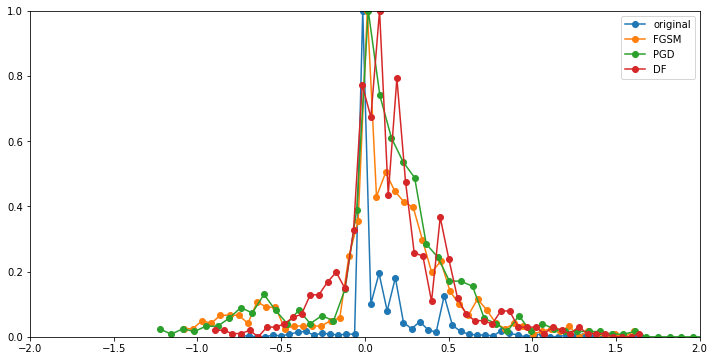

In [190]:
image_test = images_MNIST[0]

fig = plt.figure(figsize=(12,6))
plot_histogram(image_test.coefs_original['horizontal'],'original')
plot_histogram(image_test.coefs_FGSM['horizontal'],'FGSM')
plot_histogram(image_test.coefs_PGD['horizontal'],'PGD')
plot_histogram(image_test.coefs_DF['horizontal'],'DF')
plt.axis([-2,2,0,1])
plt.legend()


## Pearson's $\chi^2$ test

This test is not working for the moment

In [ ]:
import scipy.stats as stats
import scipy.integrate as integrate

# Intégrale la densité de la loi ggd entre a et b
def ggd_a_b(a, b, alpha, sigma):
  integrale, err = integrate.quad(lambda x : MSCN.ggd(x, alpha, sigma), a, b)
  return integrale

# Intégrale la densité de la loi aggd entre a et b
def aggd_a_b(a, b, alpha, sigma_left, sigma_right):
  integrale, err = integrate.quad(lambda x : MSCN.aggd(x, alpha, sigma_left, sigma_right), a, b)
  return integrale

def test_pearson_chisq(image): # Le paramètre image est de type Image
  names_images = ['original', 'FGSM attacked', 'PDG attacked', 'DF attacked']#, 'CW attacked']
  dict_images = dict(zip(names_images,[image.original, image.attack_FGSM, image.attack_PGD, image.attack_DF]))#, image.attack_CW]))
  names_coefs = ['mscn', 'horizontal', 'vertical', 'main_diagonal', 'secondary_diagonal']

  dict_coefs = dict(zip(names_images,[image.coefs_original, image.coefs_FGSM, image.coefs_PGD, image.coefs_DF]))#, image.coefs_CW]))

  N = 5 # nombre d'intervalles, i.e. le nombre de classe, i.e. le nombre de fréquences
  poles = [10*i/N-5 for i in range(N+1)] # On prend ici [-5,5] au lieu de [-\infty, + \infty], mouai, mouai (ne change pas par rapport à [-4,4] donc ça doit être ok)

  print(" "*15, end="")
  for name_coef in names_coefs:
    print("{:>20}".format(name_coef), end="")
  print("")

  # Calcul des fréquences théoriques sur l'image originale
  freq_theo = dict(zip(names_coefs,[[] for i in range(len(names_coefs))]))
  features = image.features_original
  for name_coef in names_coefs:
    if name_coef == 'mscn':
      alpha, mean, var = features['mscn']
      for i in range(N):
        freq_theo['mscn'].append( ggd_a_b(poles[i], poles[i+1], alpha, sigma=np.sqrt(var)) )
    else:
      alpha, mean, var_left, var_right = features[name_coef]
      for i in range(N):
        freq_theo[name_coef].append( aggd_a_b(poles[i], poles[i+1], alpha, np.sqrt(var_left), np.sqrt(var_right)) )

    freq_theo[name_coef] = np.array(freq_theo[name_coef])/np.sum(freq_theo[name_coef])
  
  
  # On effectue les tests pour chaque image attaquées et pour chaque type de coeffcient
  for name_i in names_images:
    print("{:>15}".format(name_i), end="")
    coefs = dict_coefs[name_i]

    for name_coef in names_coefs:
      freq_obsv = []
      for i in range(N):
        freq_obsv.append( np.sum((coefs[name_coef] >= poles[i])*(coefs[name_coef] < poles[i+1])) )
      
      # On normalise ou on s'assure qu'on est bien à 1
      freq_obsv = np.array(freq_obsv)/np.sum(freq_obsv)      

      test_stat, p_value = stats.chisquare(freq_obsv, freq_theo[name_coef], ddof = 3) # 3 car il y a 3 paramètres dans la loi ggd et aggd
      print("     {:>15.10f}".format(p_value), end="")
    print("")

In [ ]:
# Test de la fonction :
nb_image = 3
for i in range(nb_image):
  test_pearson_chisq(images_MNIST[i])
  print("----------------------------------------------------------------------------------------------------------------------"*(i!=nb_image-1))


# Sois c'est mal codé, soit Pearson n'est pas adapté à ce problème

# **4. Adversarial attacks detector**

In [191]:
indices_train = np.random.choice(range(len(images_CIFAR)), 50, replace=False)

images_CIFAR_train = []
images_CIFAR_valid = []
for i in range(len(images_CIFAR)):
  if i in indices_train:
    images_CIFAR_train.append(images_CIFAR[i])
  else:
    images_CIFAR_valid.append(images_CIFAR[i])

In [ ]:
### ATTENTION : ce code a tourné 20 minutes !
features_train = []

for image in images_CIFAR_train:
  features_train.append(image.features_original['horizontal'])

# And now try to detect!
for image in images_CIFAR_valid[:2]:
  i = 0    
  for coefs in [image.coefs_original['horizontal'], image.coefs_FGSM['horizontal']]:#, image.coefs_PGD['horizontal'], image.coefs_DF['horizontal']]:#, image.coefs_CW['horizontal']]:
    if i == 0:
      print("original (H0 or H1): ", end="")
      i+=1
    else:
      print("    FGSM (H0 or H1): ", end="")
    for mean, alpha, beta_l, beta_r in features_train:
      cdf = lambda x : aggd_cdf(x, alpha, beta_l, beta_r)
      sample = np.array(coefs).ravel()
      test_stat, p_value = stats.kstest(sample, cdf, alternative='greater') # H1 : F(x) >= cdf(x)

      if p_value < 0.05:
        print(1, end=" ")
      else:
        print(0, end=" ")
    
    print("")
  print("--"*len(images_CIFAR_train))

In [200]:
### ATTENTION : ce code a tourné 12 minutes !

# And now try to detect!
for image in images_CIFAR_valid[:2]:
  i = 0
  for coefs in [image.coefs_original['horizontal'], image.coefs_FGSM['horizontal'], image.coefs_PGD['horizontal'], image.coefs_DF['horizontal']]:#, image.coefs_CW['horizontal']]:
    if i == 0:
      print("original (H0 or H1): ", end="")
    elif i == 1:
      print("    FGSM (H0 or H1): ", end="")
    elif i == 2:
      print("     PGD (H0 or H1): ", end="")
    else:
      print("      DF (H0 or H1): ", end="")
    i += 1
    for mean, alpha, beta_l, beta_r in features_train[:15]:
      cdf = lambda x : aggd_cdf(x, alpha, beta_l, beta_r)
      sample = np.array(coefs).ravel()
      test_stat, p_value = stats.kstest(sample, cdf, alternative='greater') # H1 : F(x) >= cdf(x)

      if p_value < 0.05:
        print(1, end=" ")
      else:
        print(0, end=" ")
    
    print("")
  print("----"*15)

original (H0 or H1): 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 
    FGSM (H0 or H1): 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
     PGD (H0 or H1): 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
      DF (H0 or H1): 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 
------------------------------------------------------------
original (H0 or H1): 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 
    FGSM (H0 or H1): 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
     PGD (H0 or H1): 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
      DF (H0 or H1): 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 
------------------------------------------------------------


In [207]:
def detector(mscn_coefs_image, lam):
  nb_H0 = 0 # Numbers of H0: non-attacked

  print("_"*15)
  for mean, alpha, beta_l, beta_r in features_train[:15]:
    cdf = lambda x : aggd_cdf(x, alpha, beta_l, beta_r)
    sample = np.array(mscn_coefs_image).ravel()
    test_stat, p_value = stats.kstest(sample, cdf, alternative='greater') # H1 : F(x) >= cdf(x)
    print("#", end="")

    if p_value >= 0.05:
      nb_H0 += 1
  
  if nb_H0 < lam :
    print("\n   => Attacked image")
  else:
    print("\n   => Non-attacked image")

In [208]:
# TEST OF THE DETECTOR

coefs_1 = images_CIFAR_valid[15].coefs_FGSM['horizontal']
coefs_2 = images_CIFAR_valid[2].coefs_original['horizontal']
coefs_3 = images_CIFAR_valid[6].coefs_PGD['horizontal']
coefs_4 = images_CIFAR_valid[20].coefs_DF['horizontal']

lam = 0.1
detector(coefs_1, lam)
print("-"*50)
detector(coefs_2, lam)
print("-"*50)
detector(coefs_3, lam)
print("-"*50)
detector(coefs_4, lam)

_______________
###############
   => Attacked image
--------------------------------------------------
_______________
###############
   => Non-attacked image
--------------------------------------------------
_______________
###############
   => Attacked image
--------------------------------------------------
_______________
###############
   => Non-attacked image


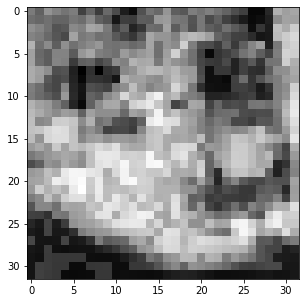

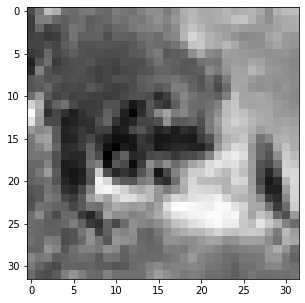

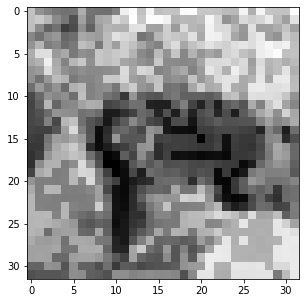

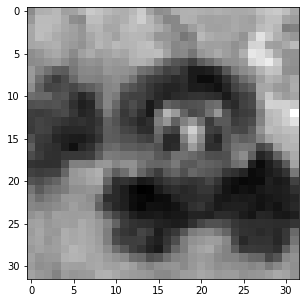

In [210]:
fig = plt.figure(figsize=(12,5))
plt.imshow(images_CIFAR_valid[15].attack_FGSM, cmap="gray")
plt.show()

fig = plt.figure(figsize=(12,5))
plt.imshow(images_CIFAR_valid[2].original, cmap="gray")
plt.show()

fig = plt.figure(figsize=(12,5))
plt.imshow(images_CIFAR_valid[6].attack_PGD, cmap="gray")
plt.show()

fig = plt.figure(figsize=(12,5))
plt.imshow(images_CIFAR_valid[20].attack_DF, cmap="gray")
plt.show()

# **5. An other method to detect adversarial attacks: SVM**

In [ ]:
from sklearn import svm
import random

In [ ]:
X = []
y = []

for image in images_MNIST:
  X.append(list(image.coefs_original['mscn'].reshape(-1)))
  y.append(0)

  X.append(list(image.coefs_FGSM['mscn'].reshape(-1)))
  y.append(1)

  X.append(list(image.coefs_DF['mscn'].reshape(-1)))
  y.append(1)

  X.append(list(image.coefs_PGD['mscn'].reshape(-1)))
  y.append(1)

X = np.array(X)
y = np.array(y)

In [ ]:
classiAttack = svm.SVC()
classiAttack.fit(X,y)
# il faudrait faire une base apprentissage et une base test
classiAttack.score(X,y)

In [ ]:
for i in random.choices(range(0,len(images_MNIST)),  k = 5):

  print("_________ " + str(i) + "____________")
  print(classiAttack.predict([list(images_MNIST[i].coefs_original['mscn'].reshape(-1))]))
  print(classiAttack.predict([list(images_MNIST[i].coefs_FGSM['mscn'].reshape(-1))]))
  print(classiAttack.predict([list(images_MNIST[i].coefs_PGD['mscn'].reshape(-1))]))
  print(classiAttack.predict([list(images_MNIST[i].coefs_DF['mscn'].reshape(-1))]))
  print("\n")